In [1]:
import os, datetime, time, re, warnings, gc, json, random, yaml, umap, pickle

from contextlib import contextmanager

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.core.common import SettingWithCopyWarning

from sklearn.cluster import MiniBatchKMeans

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

pd.set_option("display.width", 1000)
pd.set_option("display.max_columns", 256)
pd.set_option("display.max_rows", 256)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Noto Sans CJK JP']

In [2]:
df = pd.read_pickle("./structure_df_01.pkl")
df.head()

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392,1,6,0,3
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13,392,0,0,0,5
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392,0,1,0,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392,0,3,0,0
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,55,764,0,0,0,0


### 処理済み特徴量の読み込み

In [3]:
train = pd.read_pickle("./structure_train_01.pkl")
train.head()

,floor_area,pref_code,country_code,floor_1,floor_2,floor_3,CB造,PC造,RC造,SC造,SRC造,S造,W造,他造,造,0,その他,その他ガス施設,その他事務所,その他医療保健師設,その他工場,その他工場施設,その他教育研究施設,その他物販店舗,その他社寺教会,その他飲食店,その他駐車場施設,ガラスセメント工場,ゴムタイヤ製造工場,ゴルフ場,サ－ビス店舗,ショッピングセンタ－,ショ－ル－ム,パルプ紙工場,ビジネスホテル,ホテル,マンションアパ－ト,ヤ－ド,リゾ－トホテル,レジャ－娯楽施設,一般事務所,一般倉庫,一般冷蔵冷凍倉庫,一般貸事務所,事務所,付属事務所,会館,体育施設,体育館,保健福祉施設,個人住宅,光学機器時計製造工場,別荘,劇場,化学工場,医療保健施設,医薬品工場,印刷製本工場,卸売市場,厚生寮保養所,各種学校,図書館,大学高専,学生寮,家族寮,宿泊施設,寺神社,専門店,展示施設,幼稚園保育所,廃棄物処理場,弱電機器製造工場,放送新聞施設,教会,教育研究施設,新聞関係施設,旅館,機械製造工場,機械部品製造工場,流通センタ－,流通施設,火力発電所,物販店舗,特殊病院,独立住宅,独身寮,生保シリ－ズ,生産施設,病院,発電変電施設,研修所,研究施設（企業）,研究施設（教育）,社寺教会,立体駐車場,精密機器製造工場,総合病院,繊維紡績工場,自動車工場,自社専用ビル,興行場集会施設,計算センタ－事務センタ－,診療所医院,講堂,車両製造工場,造船工場,配送センタ－,量販店,金属製品加工工場,鉄道施設,銀行,集合住宅,電子機器製造工場,非鉄金属加工工場,非鉄金属精練工場,食料品工場,飲食店,駐車場施設,高校中学校
0,0.217318,0.213055,0.223924,1.010288,0.287269,-0.307628,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.050055,0.208861,0.223924,-0.331501,-0.827702,-0.307628,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-0.534205,0.208861,0.223924,-0.331501,-0.641873,-0.307628,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.420049,0.217249,0.223924,-0.331501,-0.270216,-0.307628,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,-0.518288,0.385017,1.348896,-0.331501,-0.827702,-0.307628,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### クラスタリング

In [4]:
kmeans = MiniBatchKMeans(n_clusters=10, random_state=42)
kmeans.fit(train)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=10, n_init=3, random_state=42,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

### 分類結果を分析用のデータに反映

In [5]:
df["k_class"] = kmeans.predict(train)

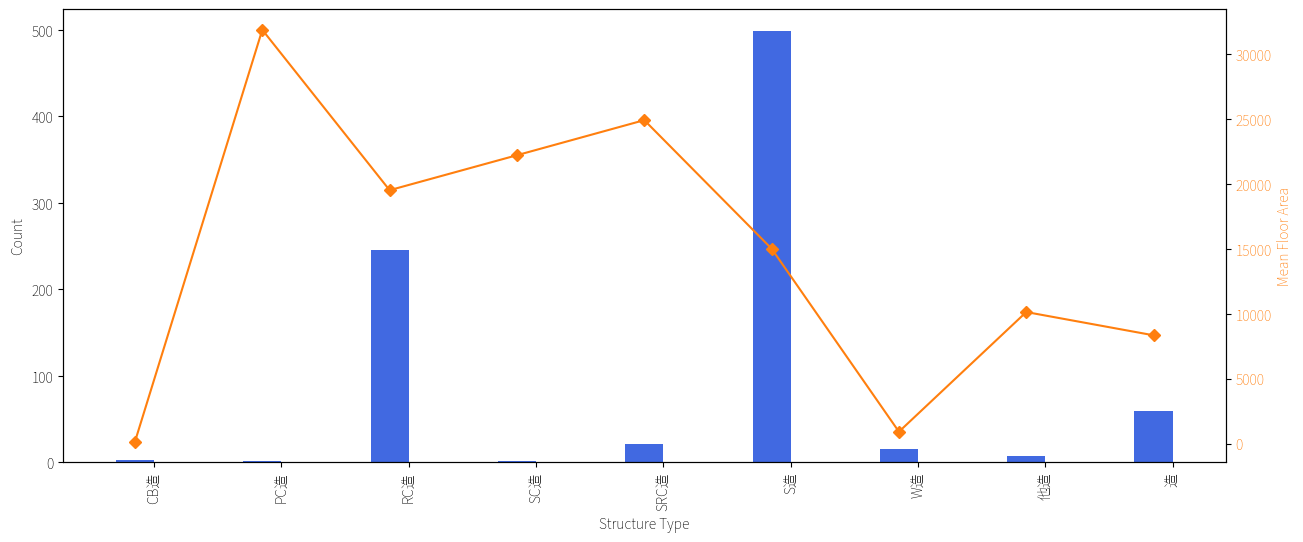

In [6]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6), dpi=100)
tt = df.groupby("structure_type").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Structure Type");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["structure_type"].unique()), rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("structure_type")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Mean Floor Area', color='tab:orange');

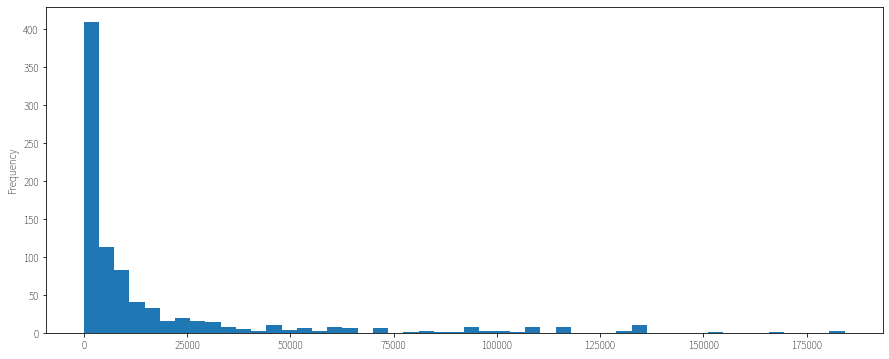

In [7]:
plt.rc('figure', figsize=(15, 6))
df["floor_area"].plot.hist(bins=50)

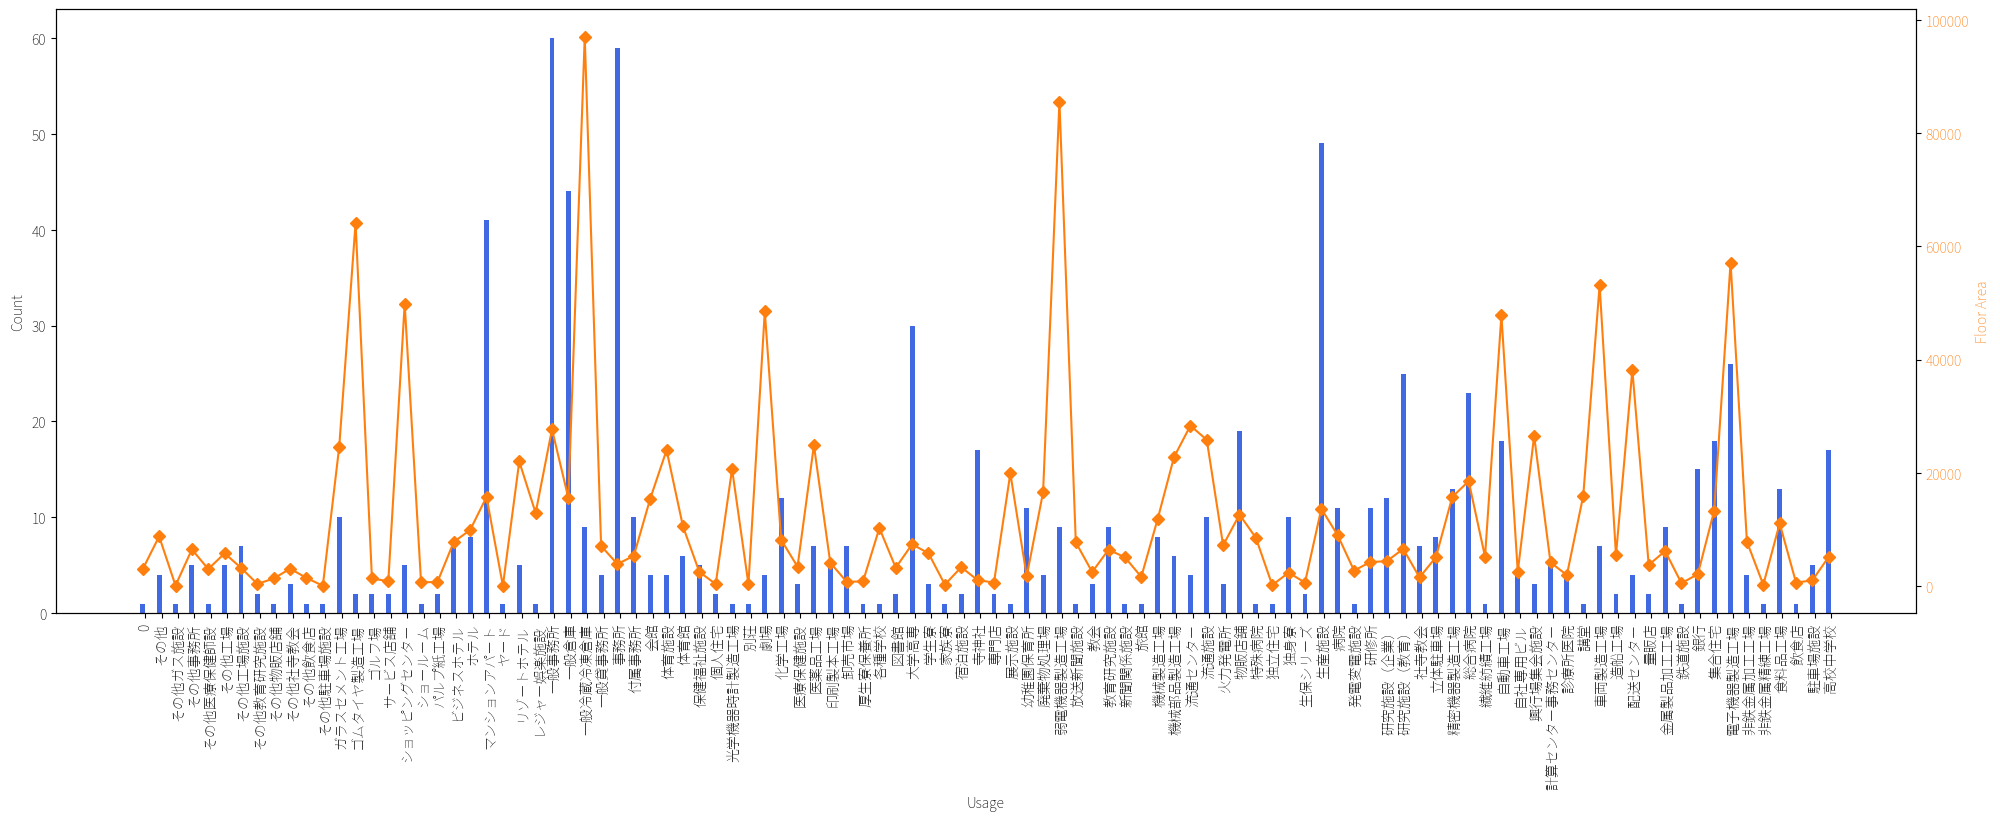

In [8]:
fig, axes = plt.subplots(1, 1, figsize=(24, 8), dpi=100)
tt = df.groupby("usage").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Usage");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["usage"].unique()), rotation=90)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("usage")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

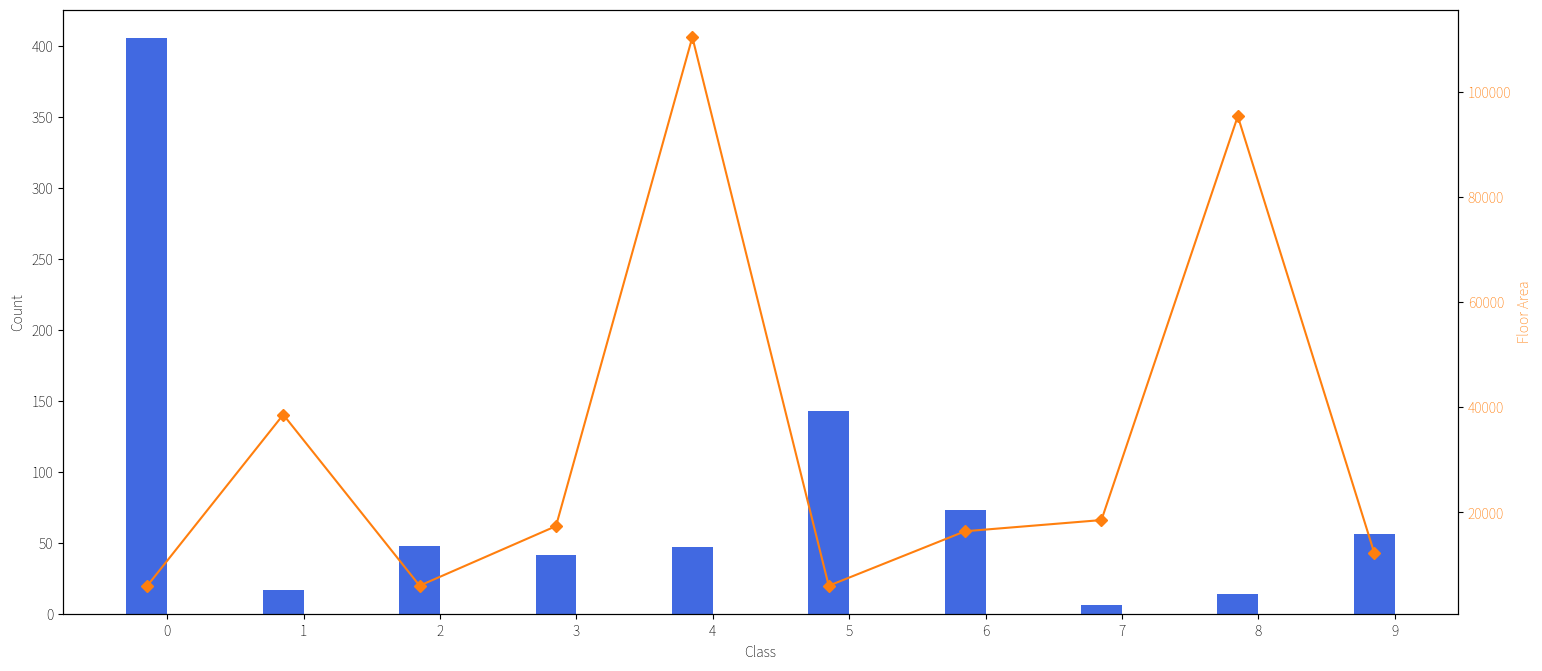

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(18, 8), dpi=100)
tt = df.groupby("k_class").size().values
ind = np.arange(len(tt))
width = 0.3

b = axes.bar(ind, tt, width, color='royalblue')
axes.set_ylabel("Count");
axes.set_xlabel("Class");
axes.set_xticks(ind + width / 2)
axes.set_xticklabels(np.sort(df["k_class"].unique()), rotation=0)

axes2 = axes.twinx()
axes2.plot(ind, df.groupby("k_class")["floor_area"].mean(), 'D-', color='tab:orange', label='Mean Floor Area');
axes2.grid(False);
axes2.tick_params(axis='y', labelcolor='tab:orange');
axes2.set_ylabel('Floor Area', color='tab:orange');

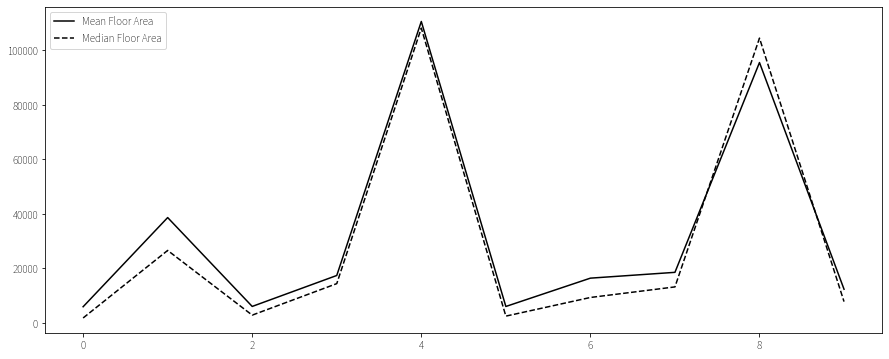

In [10]:
fig = plt.figure(); ax = fig.add_subplot(1, 1, 1)
ax.plot(df.groupby("k_class")["floor_area"].mean(), 'k', label='Mean Floor Area')
ax.plot(df.groupby("k_class")["floor_area"].median(), 'k--', label='Median Floor Area')
ax.legend(loc='best')

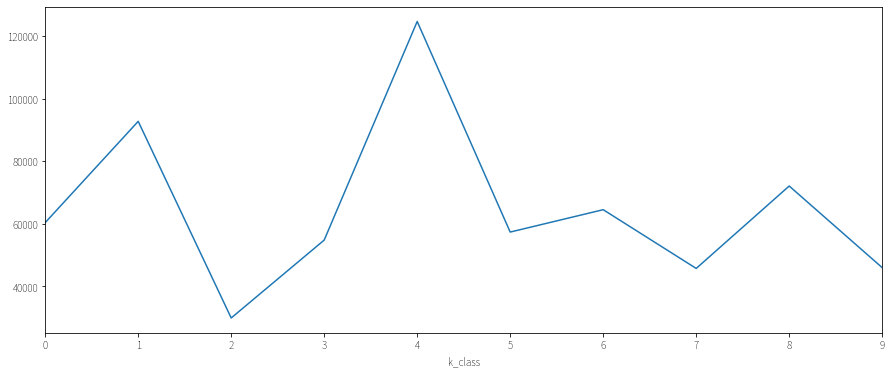

In [11]:
tmp = df.groupby("k_class").agg({"floor_area": ["min", "max"]})
tmp["diff"] = tmp[("floor_area", "max")] - tmp[("floor_area", "min")]
tmp["diff"].plot()

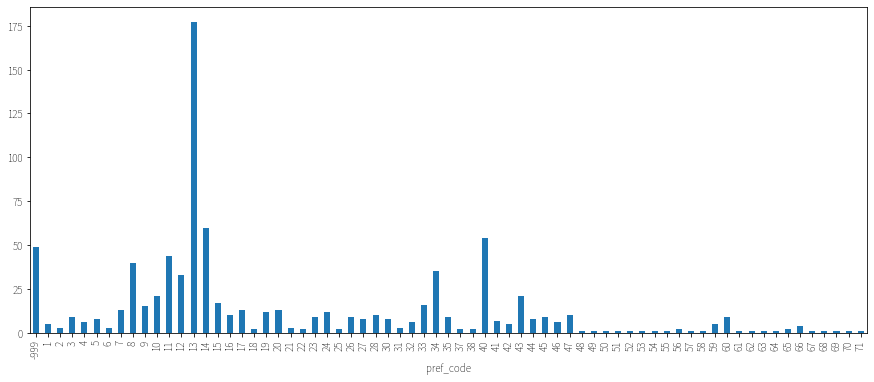

In [12]:
df.groupby("pref_code").size().plot.bar()

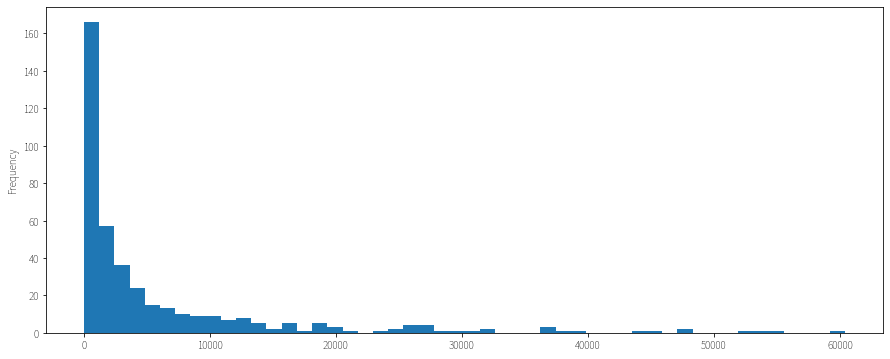

In [13]:
df[df["k_class"]==0]["floor_area"].plot.hist(bins=50)

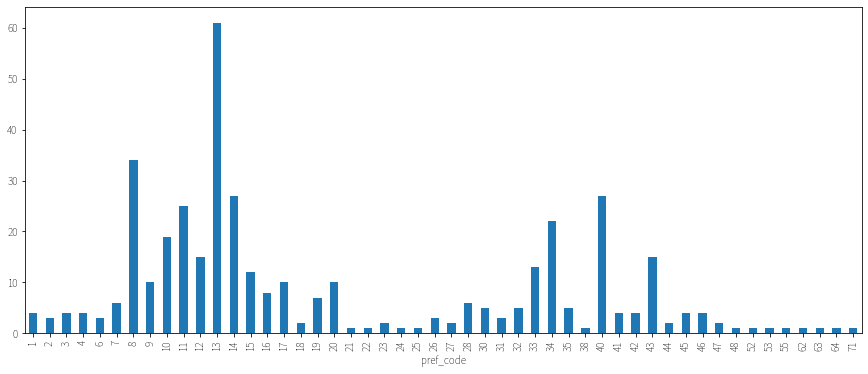

In [14]:
df[df["k_class"]==0].groupby("pref_code").size().plot.bar()

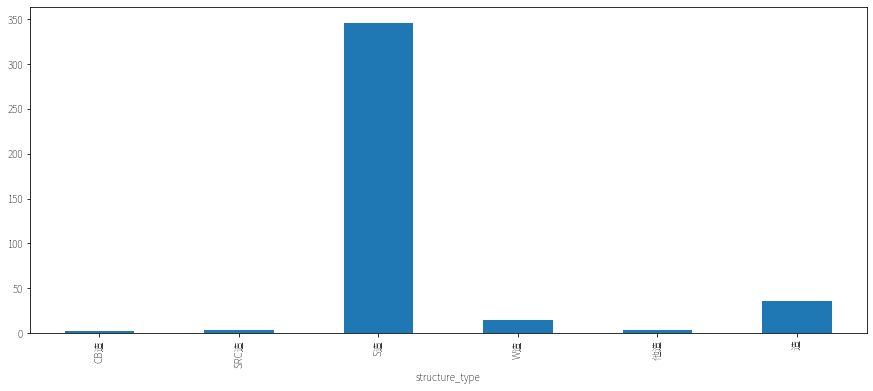

In [15]:
df[df["k_class"]==0].groupby("structure_type").size().plot.bar()

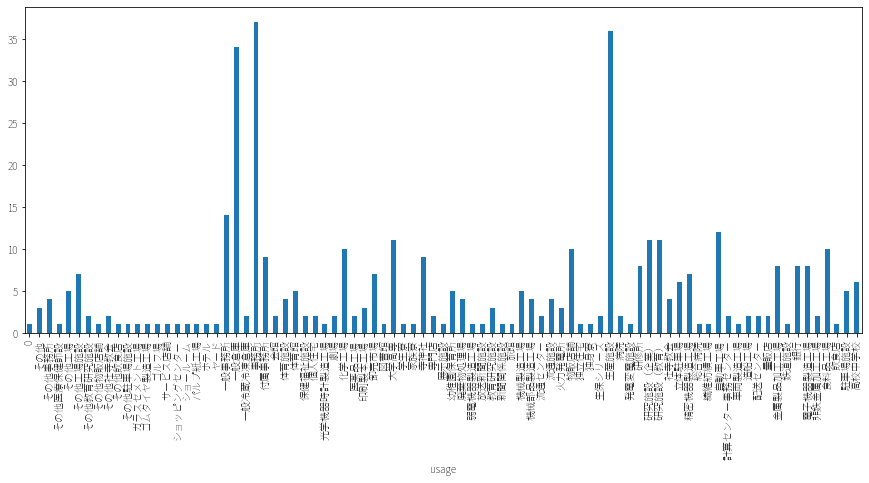

In [16]:
df[df["k_class"]==0].groupby("usage").size().plot.bar()

In [17]:
df[df["k_class"]==0]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
2,79 09A245A,八幡大神社楼門新築計画,社寺教会,東京都三鷹市,30.12,0-1-0,W造,13,392,0,1,0,0
3,75 09A014,デンカ生研鏡田工場５５号棟建設工事,付属事務所,新潟県五泉市,3400.00,0-3-0,S造,15,392,0,3,0,0
4,93 09A002,ホンダ・タイ工場環境試験室増設工事,自動車工場,海外タイ アユタヤ県,500.00,0-0-0,造,55,764,0,0,0,0
7,79 09A540C,花王和歌山新研究施設建設計画（温室）,研究施設（教育）,和歌山県和歌山市,2361.00,0-3-0,S造,30,392,0,3,0,0
17,79 09B033B,シャープ福山第２センタービル計画,付属事務所,広島県福山市,10000.00,0-5-0,S造,34,392,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
843,76 18A020,日本生命会郡山支社会津営業部新築工事,生保シリ－ズ,福島県会津若松市,379.00,0-1-0,S造,7,392,0,1,0,0
844,79 17A315D,昭南荘建替計画・家具,個人住宅,神奈川県足柄下郡箱根町,350.00,1-1-0,W造,14,392,1,1,0,0
845,74 18B004,日本生命鹿児島支社串木野オフィス新築,一般事務所,鹿児島県いちき串木野市,310.00,0-1-0,S造,46,392,0,1,0,0
847,64 18A047,関東電化工業渋川工場高圧ガス容器置場新築,一般倉庫,群馬県渋川市,214.00,0-1-0,S造,10,392,0,1,0,0


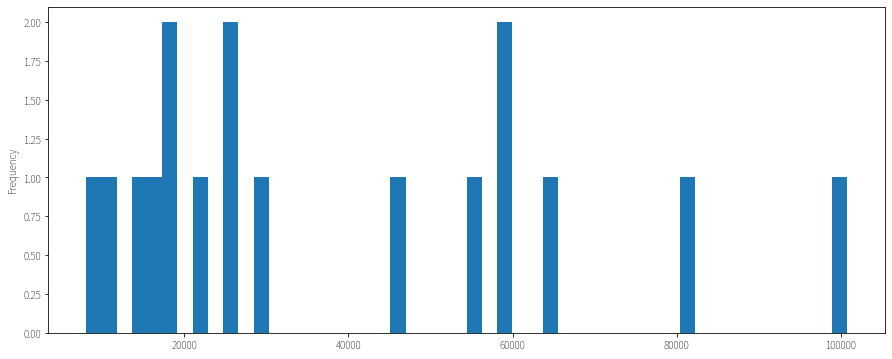

In [18]:
df[df["k_class"]==1]["floor_area"].plot.hist(bins=50)

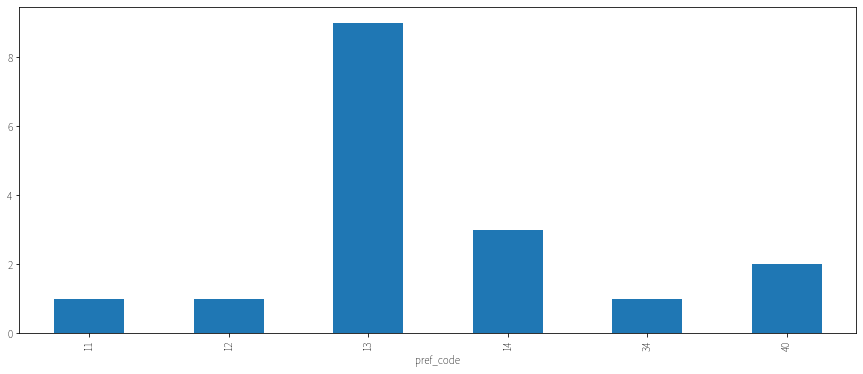

In [19]:
df[df["k_class"]==1].groupby("pref_code").size().plot.bar()

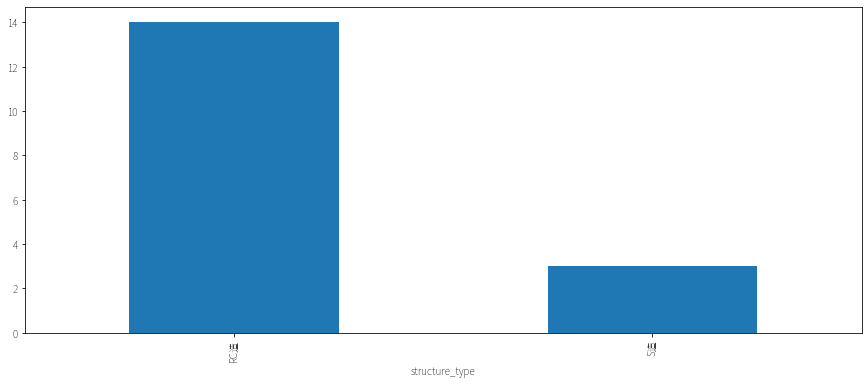

In [20]:
df[df["k_class"]==1].groupby("structure_type").size().plot.bar()

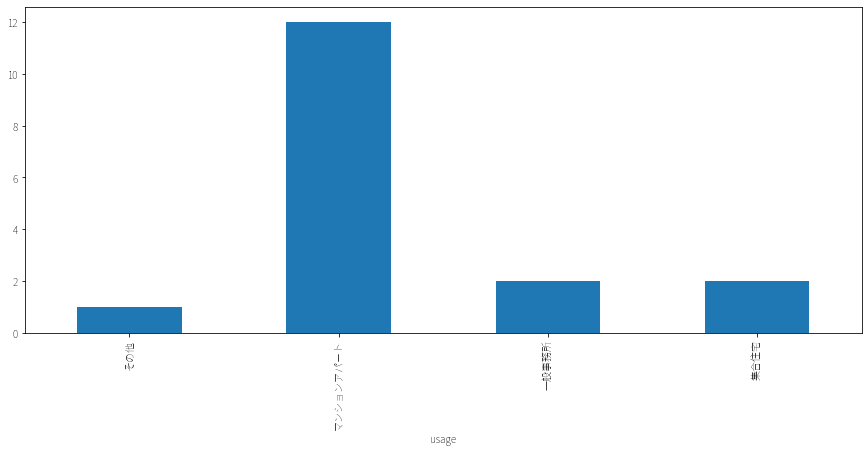

In [21]:
df[df["k_class"]==1].groupby("usage").size().plot.bar()

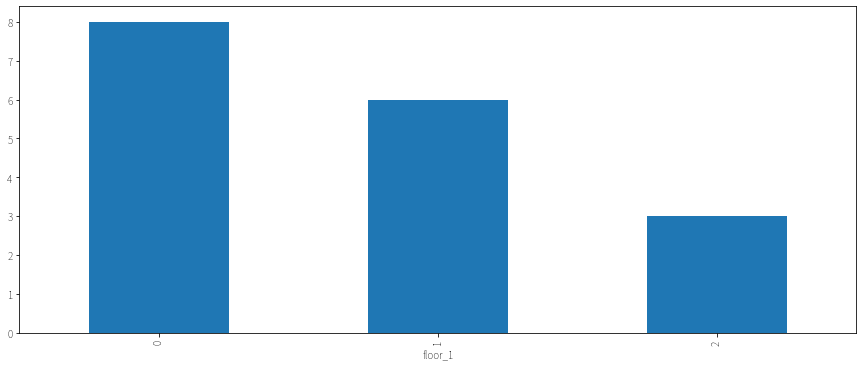

In [22]:
df[df["k_class"]==1].groupby("floor_1").size().plot.bar()

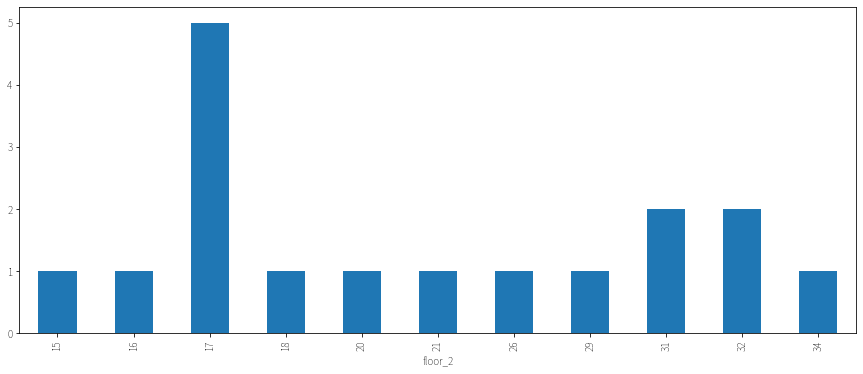

In [23]:
df[df["k_class"]==1].groupby("floor_2").size().plot.bar()

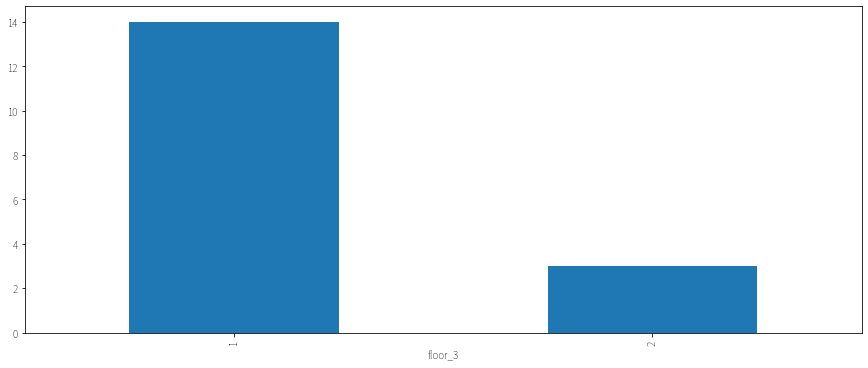

In [24]:
df[df["k_class"]==1].groupby("floor_3").size().plot.bar()

In [25]:
df[df["k_class"]==1]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
126,79 10A236A,※千代田区四番町計画,マンションアパ－ト,東京都千代田区,21884.00,1-15-1,RC造,13,392,1,15,1,1
187,79 07A400I,立川駅北口西地区再開発事業（集合住宅）,集合住宅,東京都立川市,59503.85,2-32-2,RC造,13,392,2,32,2,1
200,79 07A752H,芝浦一丁目計画（設計）,マンションアパ－ト,東京都港区,100758.02,0-34-1,RC造,13,392,0,34,1,1
211,79 07A400H,立川駅北口西側地区再開発事業（設計業務）,集合住宅,東京都立川市,59503.85,2-32-2,RC造,13,392,2,32,2,1
248,79 11A726A,渋谷水野ビル建替計画,マンションアパ－ト,東京都渋谷区,8027.51,1-18-1,RC造,13,392,1,18,1,1
254,79 09B161B,本郷一丁目プロジェクト,マンションアパ－ト,東京都文京区,9964.00,1-17-1,RC造,13,392,1,17,1,1
258,79 07B171G,調布駅南口東地区再開発計画,マンションアパ－ト,東京都調布市,25372.09,1-16-1,RC造,13,392,1,16,1,1
269,79 10B172B,新豊洲プロジェクトＢ－２地区計画,マンションアパ－ト,東京都江東区,64549.44,1-31-1,RC造,13,392,1,31,1,1
319,79 06B617E,幕張ベイタウンＳＨ２街区（その２）,マンションアパ－ト,千葉県千葉市美浜区,46142.45,0-31-1,RC造,12,392,0,31,1,1
337,79 12B005A,丸仁豊洲５丁目プロジェクト,マンションアパ－ト,東京都江東区,15593.79,0-17-1,RC造,13,392,0,17,1,1


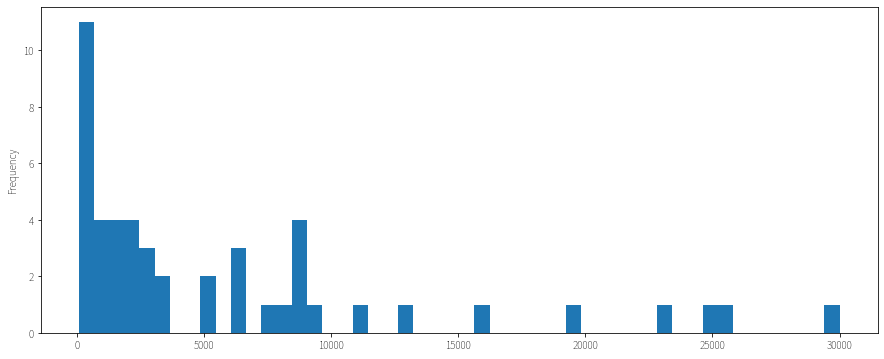

In [26]:
df[df["k_class"]==2]["floor_area"].plot.hist(bins=50)

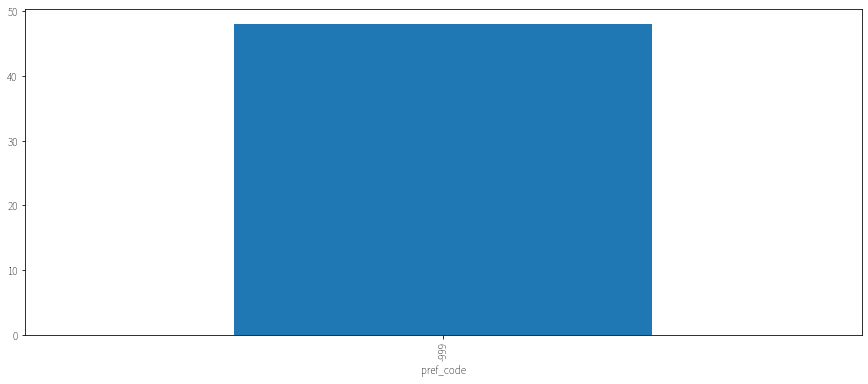

In [27]:
df[df["k_class"]==2].groupby("pref_code").size().plot.bar()

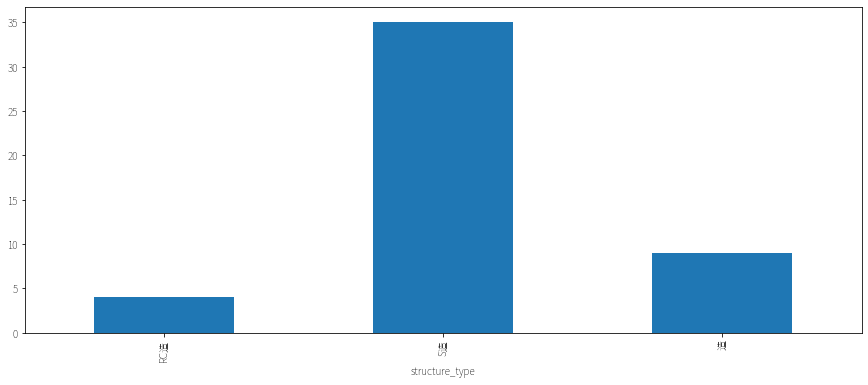

In [28]:
df[df["k_class"]==2].groupby("structure_type").size().plot.bar()

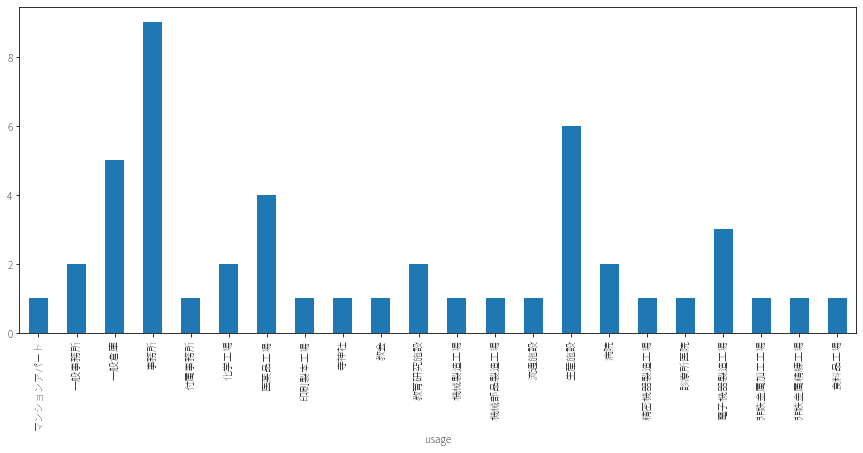

In [29]:
df[df["k_class"]==2].groupby("usage").size().plot.bar()

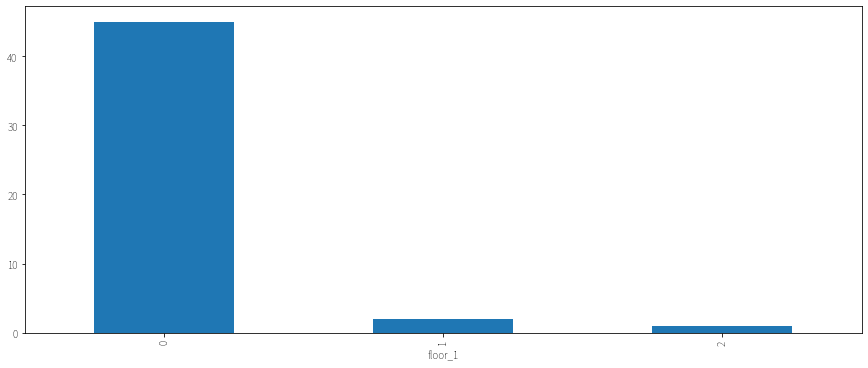

In [30]:
df[df["k_class"]==2].groupby("floor_1").size().plot.bar()

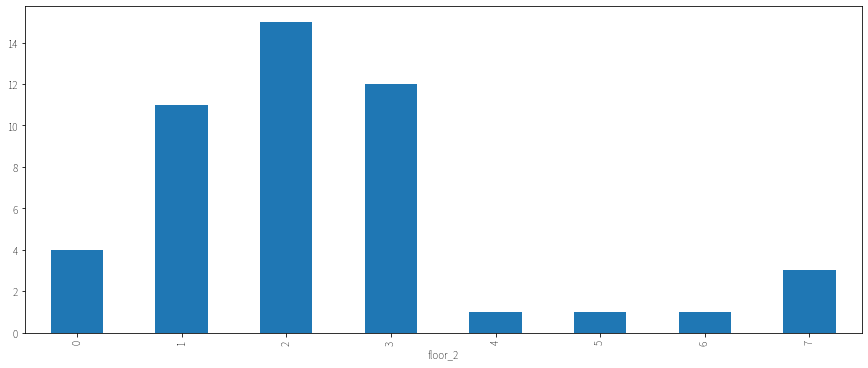

In [31]:
df[df["k_class"]==2].groupby("floor_2").size().plot.bar()

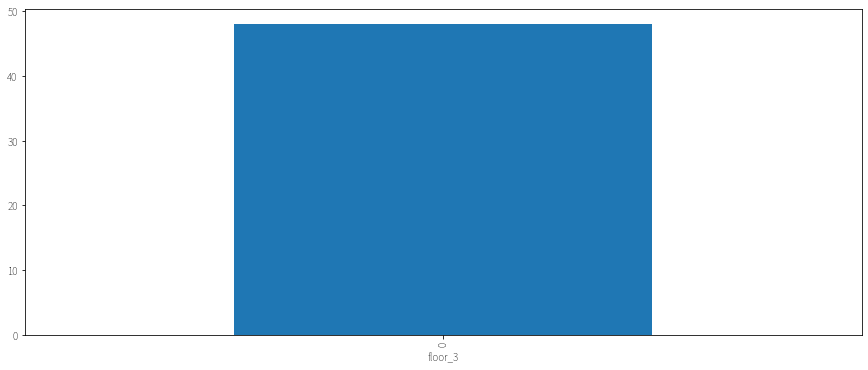

In [32]:
df[df["k_class"]==2].groupby("floor_3").size().plot.bar()

In [33]:
df[df["k_class"]==2]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
12,74 09A089,熊本工機本社工場荷捌き場新築工事,生産施設,0,110.00,0-1-0,S造,-999,-999,0,1,0,2
20,74 08B005A,宮崎県民共済自社ビル（設計変更対応）,事務所,0,3000.00,0-5-0,RC造,-999,-999,0,5,0,2
45,74 07B010A,第一生命厳原支部（実施・監理）,事務所,0,316.00,0-2-0,RC造,-999,-999,0,2,0,2
56,75 10A026,ＮＩＰＰＯ北信越支店社屋新築工事,事務所,0,1128.00,0-3-0,S造,-999,-999,0,3,0,2
60,75 10A038,コマツ粟津工場パワートレイン試験棟建設工,機械製造工場,0,6244.00,0-2-0,S造,-999,-999,0,2,0,2
64,75 10A012,遠藤印刷事務所兼工場新築工事,一般事務所,0,1761.00,0-2-0,S造,-999,-999,0,2,0,2
82,64 10A074B,松屋フーズ川島物流センター計画実施設計,食料品工場,0,13186.00,0-3-0,S造,-999,-999,0,3,0,2
95,75 10A017,三徳磁石原料製造電気室建設工事,非鉄金属精練工場,0,220.00,0-1-0,造,-999,-999,0,1,0,2
100,64 10B008,トーシンウイング新つくば工場新築工事,生産施設,0,1650.00,0-0-0,造,-999,-999,0,0,0,2
104,64 09B068A,岩谷瓦斯甲府工場ＬＧＣ充填施設土木建築,生産施設,0,110.00,0-1-0,S造,-999,-999,0,1,0,2


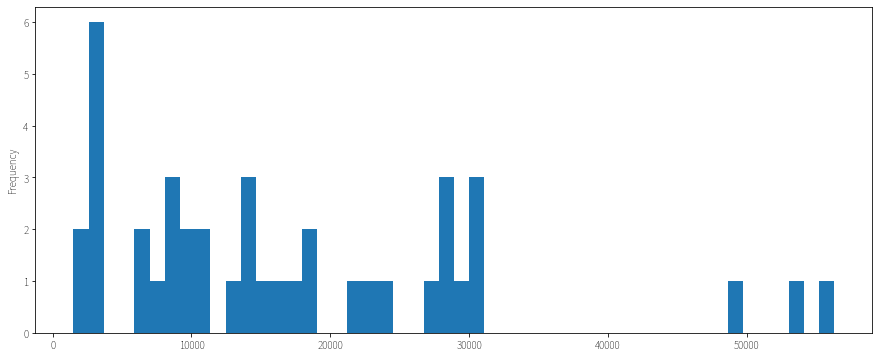

In [34]:
df[df["k_class"]==3]["floor_area"].plot.hist(bins=50)

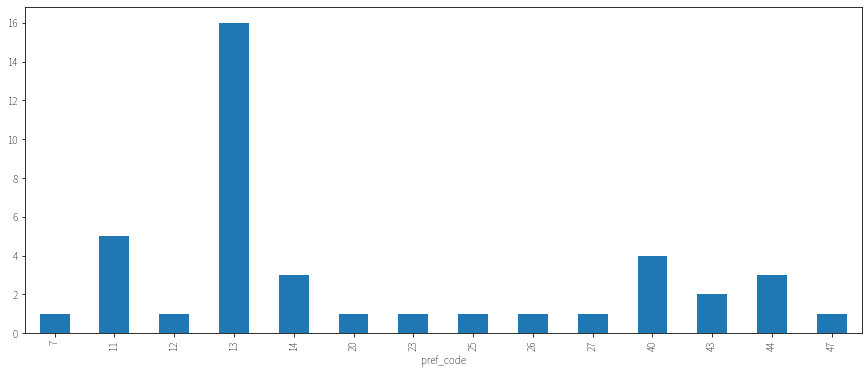

In [35]:
df[df["k_class"]==3].groupby("pref_code").size().plot.bar()

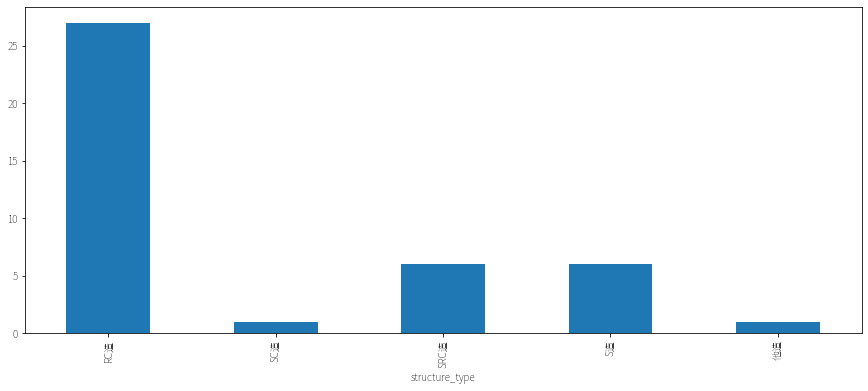

In [36]:
df[df["k_class"]==3].groupby("structure_type").size().plot.bar()

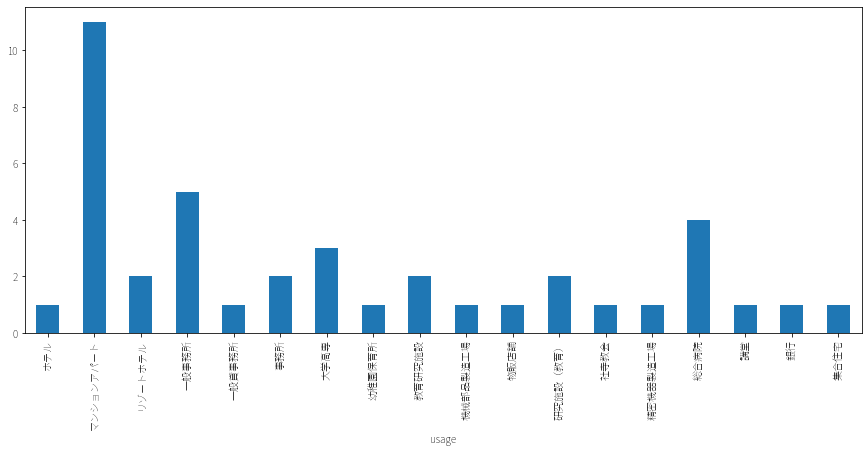

In [37]:
df[df["k_class"]==3].groupby("usage").size().plot.bar()

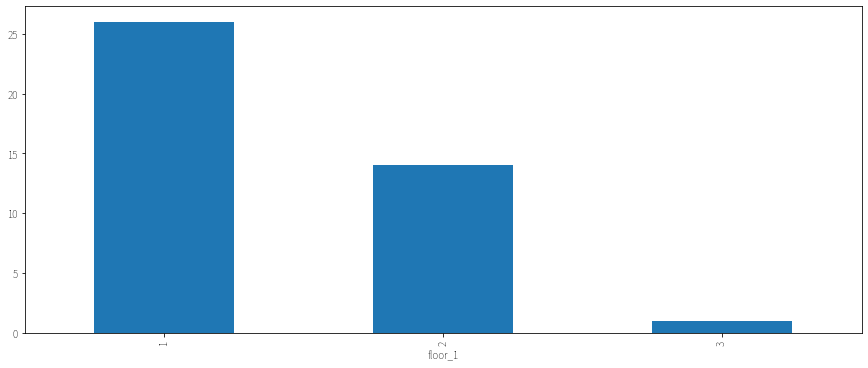

In [38]:
df[df["k_class"]==3].groupby("floor_1").size().plot.bar()

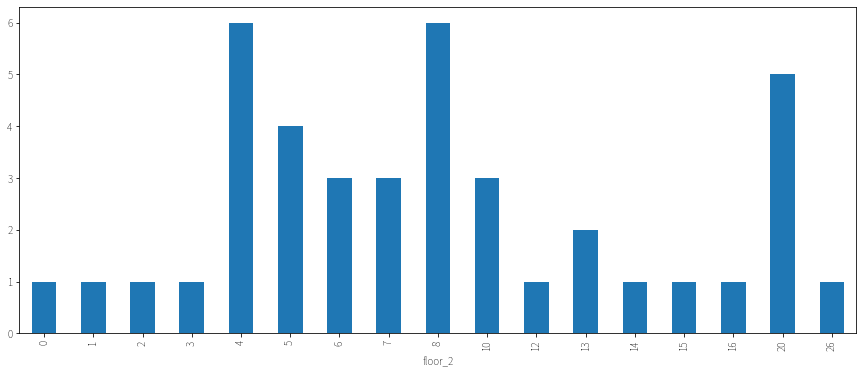

In [39]:
df[df["k_class"]==3].groupby("floor_2").size().plot.bar()

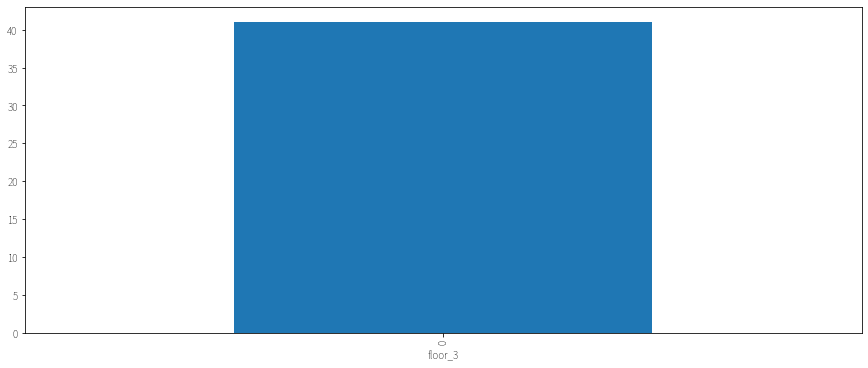

In [40]:
df[df["k_class"]==3].groupby("floor_3").size().plot.bar()

In [41]:
df[df["k_class"]==3]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
0,79 07B198B,（仮称）ＨＴＣ技術センター新築工事,研究施設（教育）,神奈川県横浜市都筑区,22214.97,1-6-0,SC造,14,392,1,6,0,3
5,79 04B878C,市川一丁目計画（テナント対応）,マンションアパ－ト,千葉県市川市,7218.81,1-13-0,RC造,12,392,1,13,0,3
11,79 06B190B,上野学園ホール棟テナントＡ対応,講堂,東京都台東区,15948.79,2-13-0,SRC造,13,392,2,13,0,3
52,79 09B514A,大和ハウス工業 南青山六丁目計画,マンションアパ－ト,東京都港区,13783.21,2-8-0,RC造,13,392,2,8,0,3
62,79 10A437A,※東急瀬田四丁目計画,マンションアパ－ト,東京都世田谷区,3404.54,1-3-0,RC造,13,392,1,3,0,3
89,79 10A169B,（仮称）新子安計画,マンションアパ－ト,神奈川県横浜市神奈川区,10828.17,1-7-0,RC造,14,392,1,7,0,3
117,79 09B264A,狸穴マンション計画,マンションアパ－ト,東京都港区,18161.34,2-8-0,RC造,13,392,2,8,0,3
129,79 05A058E,月島一丁目地区再開発計画（Ｂ棟）,マンションアパ－ト,東京都中央区,3417.16,1-12-0,RC造,13,392,1,12,0,3
130,79 10B355A,本門佛立宗宗務本庁舎建替計画,社寺教会,京都府京都市上京区,3391.50,1-4-0,RC造,26,392,1,4,0,3
139,79 10A140B,京橋一丁目ＯＭ計画,一般貸事務所,東京都中央区,9670.33,1-8-0,RC造,13,392,1,8,0,3


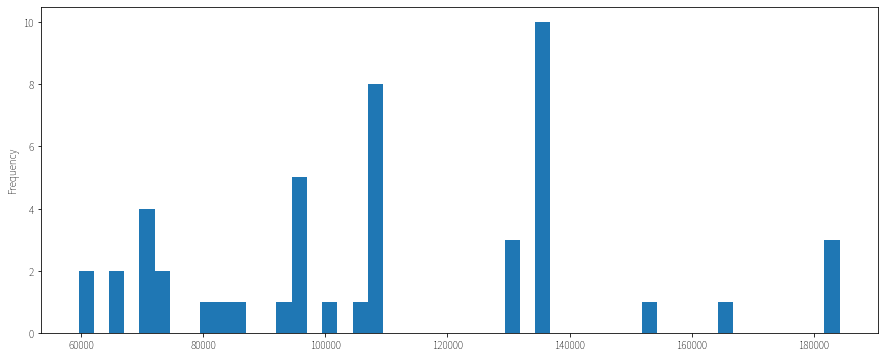

In [42]:
df[df["k_class"]==4]["floor_area"].plot.hist(bins=50)

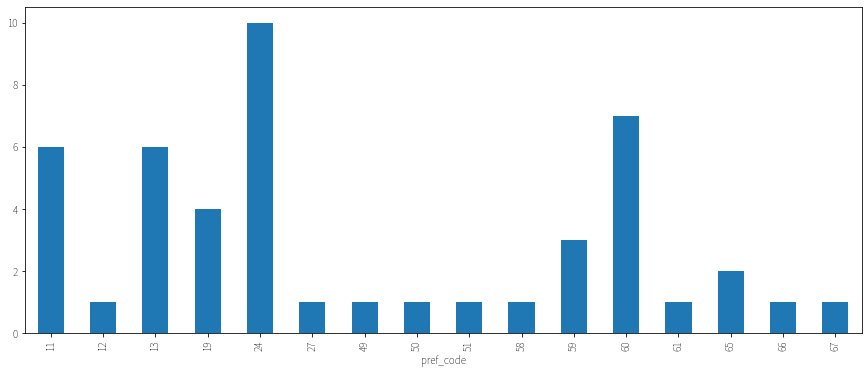

In [43]:
df[df["k_class"]==4].groupby("pref_code").size().plot.bar()

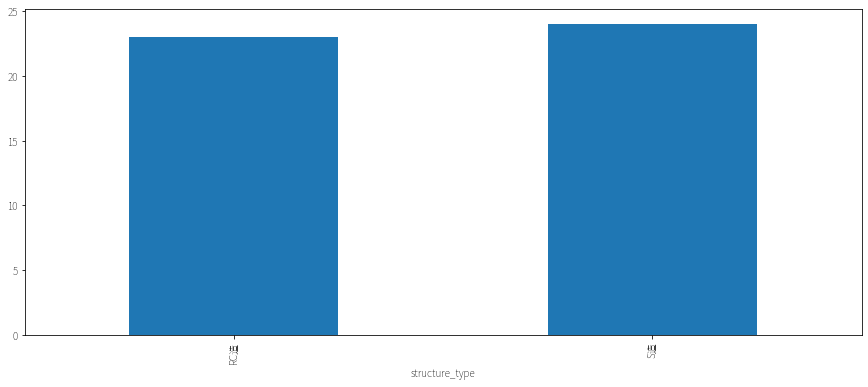

In [44]:
df[df["k_class"]==4].groupby("structure_type").size().plot.bar()

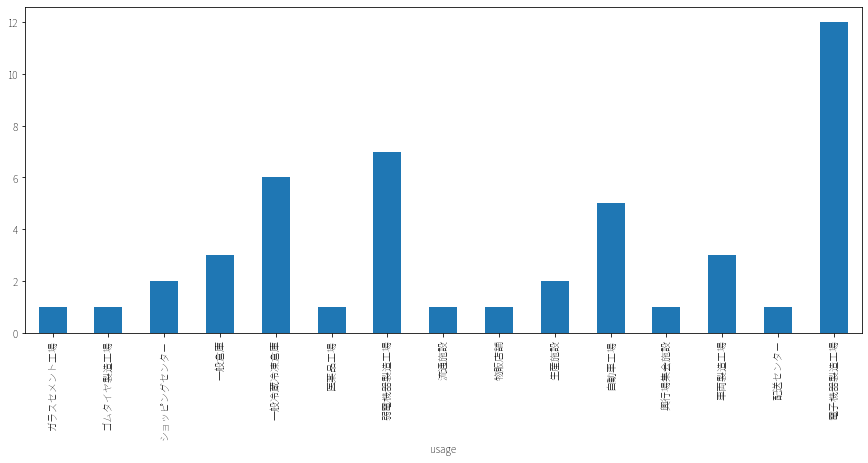

In [45]:
df[df["k_class"]==4].groupby("usage").size().plot.bar()

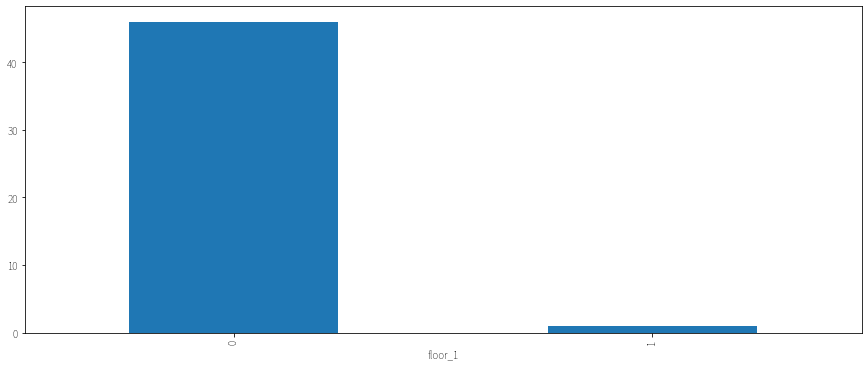

In [46]:
df[df["k_class"]==4].groupby("floor_1").size().plot.bar()

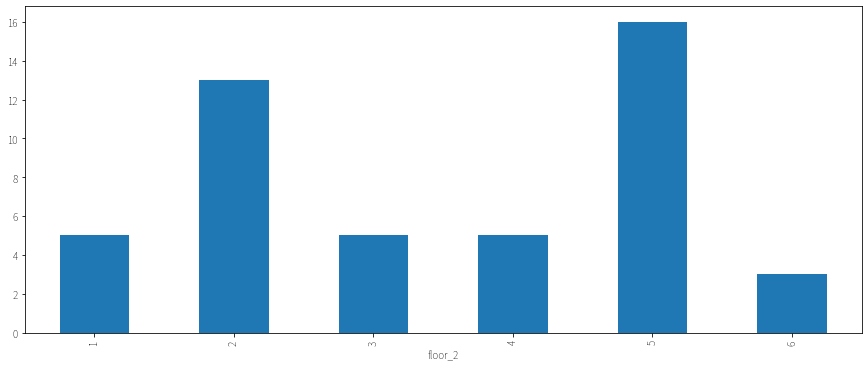

In [47]:
df[df["k_class"]==4].groupby("floor_2").size().plot.bar()

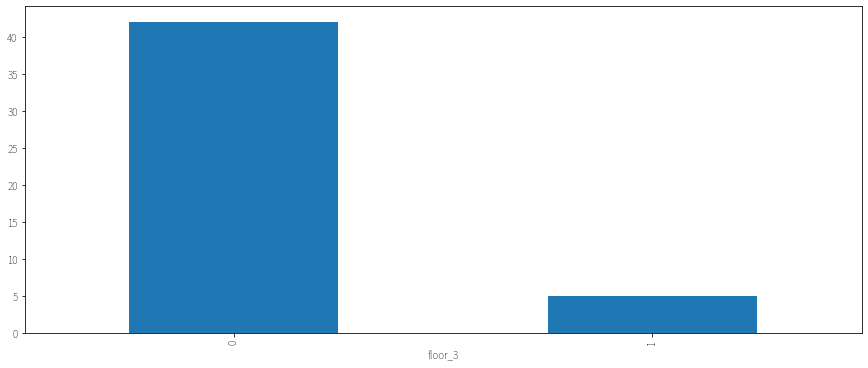

In [48]:
df[df["k_class"]==4].groupby("floor_3").size().plot.bar()

In [49]:
df[df["k_class"]==4]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
14,79 08A148B,イオンモール甲府昭和町ＳＣジャスコＢ工事,物販店舗,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,19,392,0,3,0,4
15,79 08A148C,イオンモール甲府昭和町ＳＣ（防災計画）,ショッピングセンタ－,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,19,392,0,3,0,4
16,79 08A148D,イオンモール甲府昭和町ＳＣ（シネマ）,興行場集会施設,山梨県中巨摩郡昭和町,70657.00,0-3-0,S造,19,392,0,3,0,4
26,79 08A148E,イオンモール甲府昭和町ＳＣ（熱源受託工事,ショッピングセンタ－,山梨県中巨摩郡昭和町,70657.00,0-3-0,RC造,19,392,0,3,0,4
31,79 07B471B,プロロジスパーク埼玉川島Ⅱ期,流通施設,埼玉県比企郡川島町,166659.70,0-5-1,RC造,11,392,0,5,1,4
75,79 10B200A,ホンダ寄居工場建設１期建築工事Ｓ工区,自動車工場,埼玉県大里郡寄居町,184227.00,0-4-0,S造,11,392,0,4,0,4
79,79 08A090D,東芝四日市メモリ第５製造棟（棟間搬送）,電子機器製造工場,三重県四日市市,96000.00,0-5-0,S造,24,392,0,5,0,4
153,93 10A006S,ブリヂストンインド第２工場新築工事,ゴムタイヤ製造工場,海外インド マハラシュトプネ,96846.36,0-1-0,S造,51,356,0,1,0,4
192,79 11B392A,キヤノンフィリピン工場新築工事,生産施設,海外フィリピン バタンガス州,83437.69,0-2-0,RC造,61,608,0,2,0,4
227,79 11A027B,合肥ニプロ新工場建設工事,医薬品工場,海外中国 安微省,100463.00,0-2-1,RC造,67,156,0,2,1,4


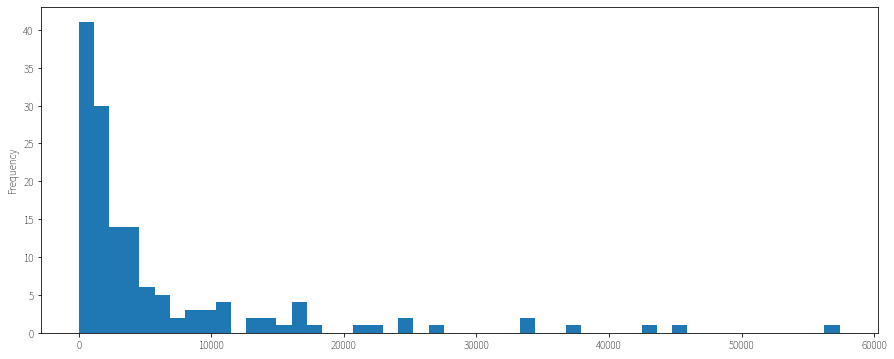

In [50]:
df[df["k_class"]==5]["floor_area"].plot.hist(bins=50)

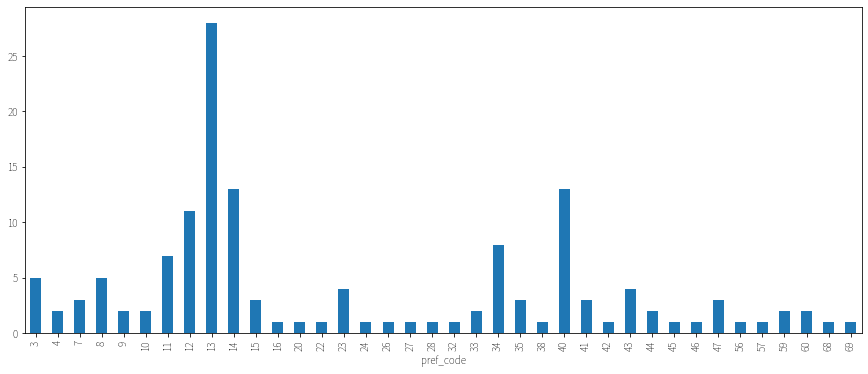

In [51]:
df[df["k_class"]==5].groupby("pref_code").size().plot.bar()

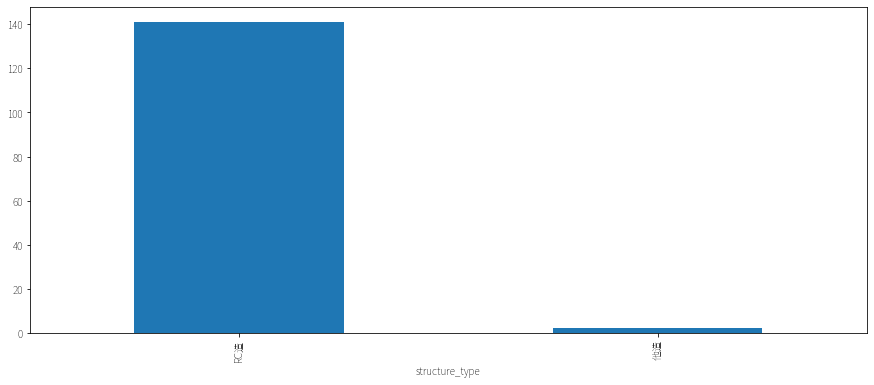

In [52]:
df[df["k_class"]==5].groupby("structure_type").size().plot.bar()

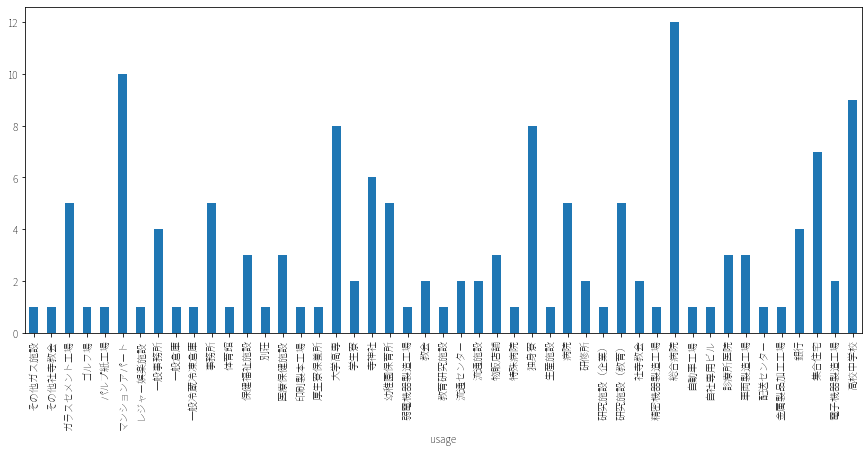

In [53]:
df[df["k_class"]==5].groupby("usage").size().plot.bar()

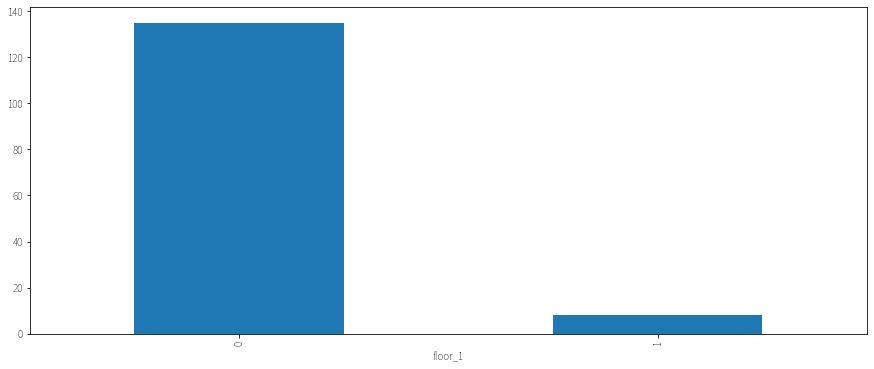

In [54]:
df[df["k_class"]==5].groupby("floor_1").size().plot.bar()

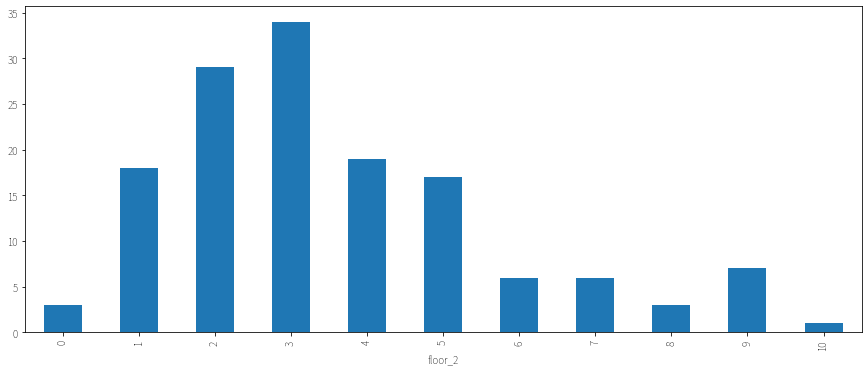

In [55]:
df[df["k_class"]==5].groupby("floor_2").size().plot.bar()

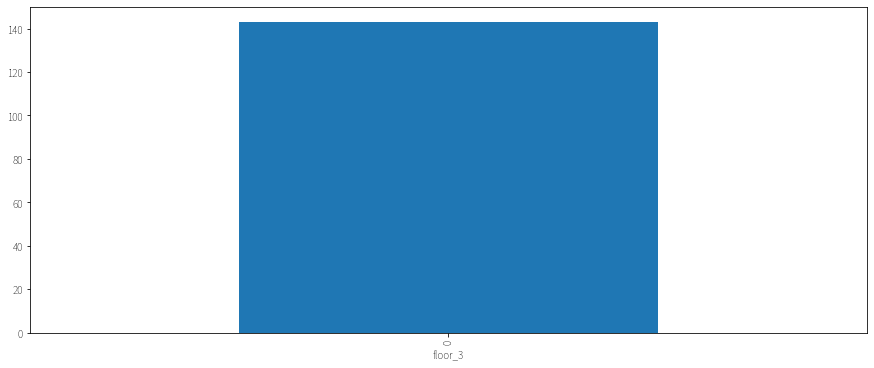

In [56]:
df[df["k_class"]==5].groupby("floor_3").size().plot.bar()

In [57]:
df[df["k_class"]==5]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
1,79 08B250B,国立音楽大学新校舎建設工事,大学高専,東京都立川市,17277.40,0-0-0,RC造,13,392,0,0,0,5
8,79 09A556A,※東邦薬品熊本物流センター計画,流通センタ－,熊本県荒尾市,15278.40,0-2-0,RC造,43,392,0,2,0,5
9,79 08B129F,慶應義塾（矢上Ｆ）テクロノジー棟新築,研究施設（教育）,神奈川県横浜市港北区,1895.78,0-3-0,RC造,14,392,0,3,0,5
18,79 09A255B,伊豆ベロドローム建設計画,レジャ－娯楽施設,静岡県伊豆市,12905.00,1-3-0,RC造,22,392,1,3,0,5
24,79 08B129J,慶應義塾（矢上Ｊ）付属棟移転①（自工研）,研究施設（教育）,神奈川県横浜市港北区,125.00,0-1-0,RC造,14,392,0,1,0,5
25,79 07B503C,目黒不動尊瀧泉寺供養塔新築工事,社寺教会,東京都目黒区,3.98,0-1-0,RC造,13,392,0,1,0,5
29,70 09A014,百五銀行豊田支店計画,銀行,愛知県豊田市,744.84,0-2-0,RC造,23,392,0,2,0,5
35,74S09A004,すがお内科クリニック新築工事,病院,福岡県福岡市城南区,223.00,0-2-0,RC造,40,392,0,2,0,5
38,74 09A054,ふたば幼稚園子育て支援施設計画,幼稚園保育所,佐賀県佐賀市,300.00,0-1-0,RC造,41,392,0,1,0,5
41,79 09A116B,国際神南ビル建替計画,マンションアパ－ト,東京都渋谷区,1350.90,0-9-0,RC造,13,392,0,9,0,5


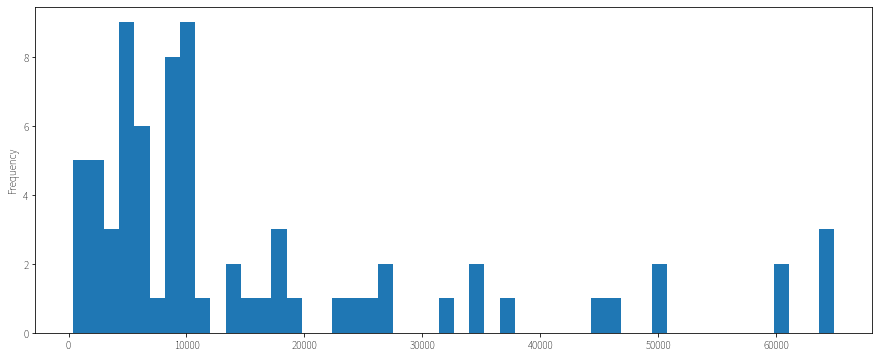

In [58]:
df[df["k_class"]==6]["floor_area"].plot.hist(bins=50)

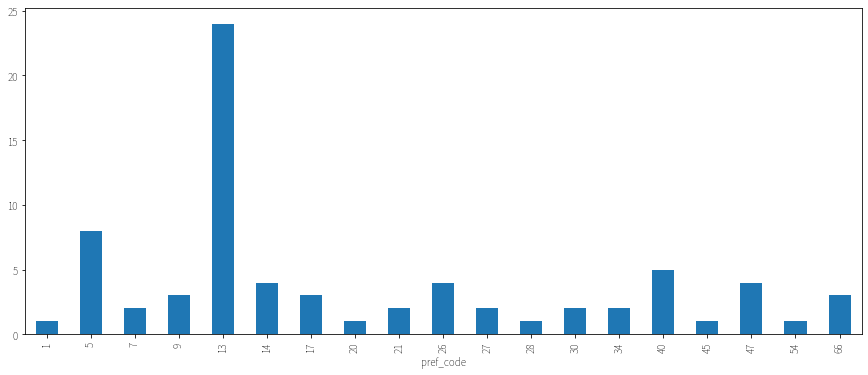

In [59]:
df[df["k_class"]==6].groupby("pref_code").size().plot.bar()

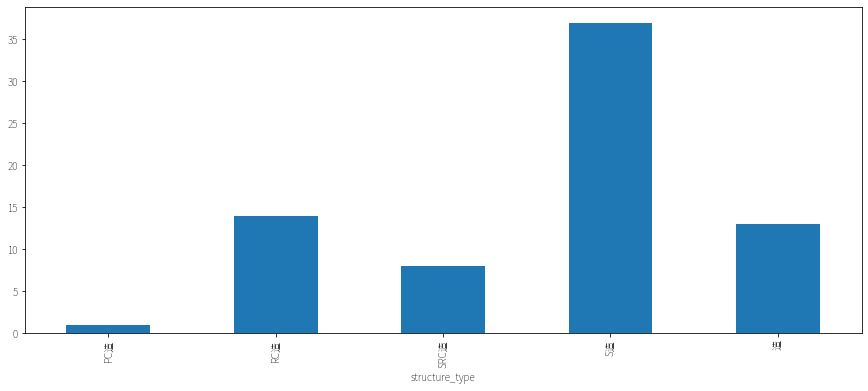

In [60]:
df[df["k_class"]==6].groupby("structure_type").size().plot.bar()

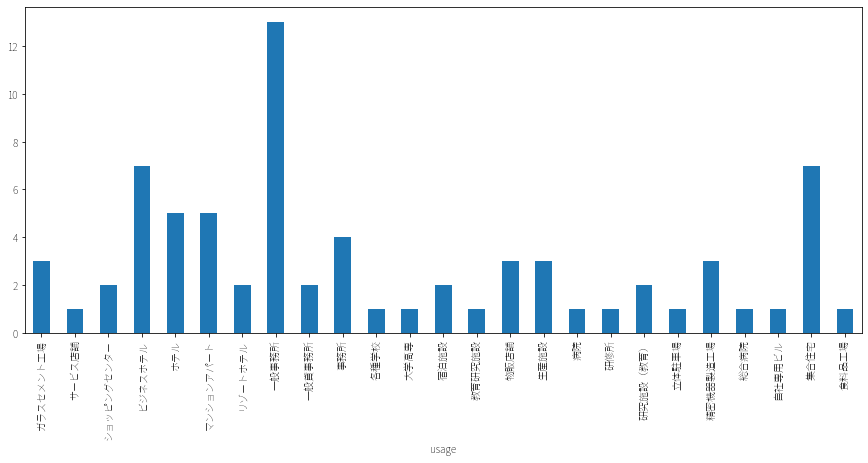

In [61]:
df[df["k_class"]==6].groupby("usage").size().plot.bar()

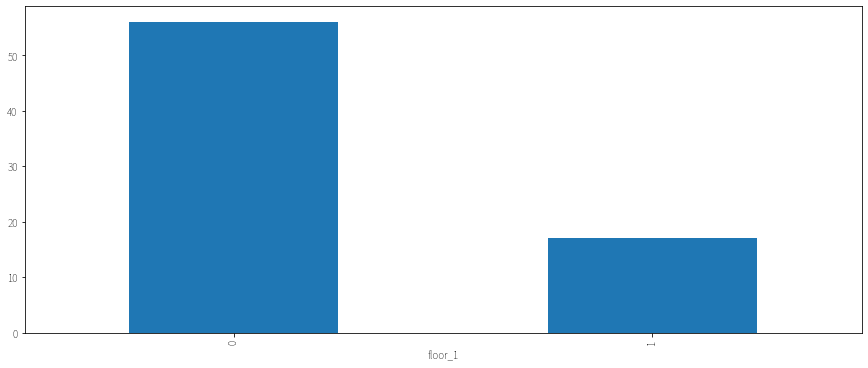

In [62]:
df[df["k_class"]==6].groupby("floor_1").size().plot.bar()

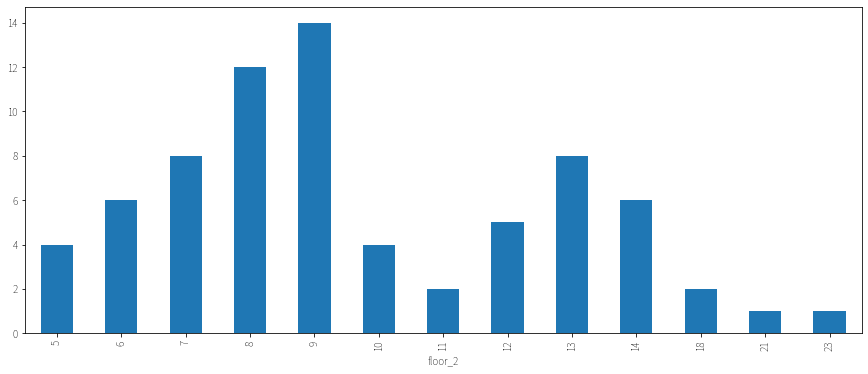

In [63]:
df[df["k_class"]==6].groupby("floor_2").size().plot.bar()

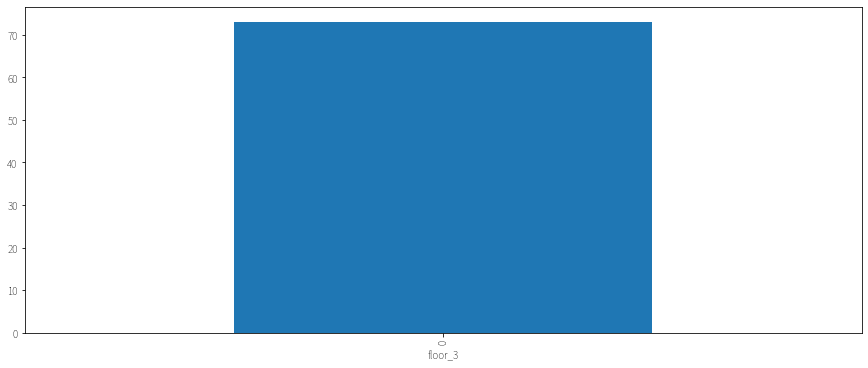

In [64]:
df[df["k_class"]==6].groupby("floor_3").size().plot.bar()

In [65]:
df[df["k_class"]==6]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
10,79 04A763E,島忠調布店新築工事（工期延長後）,ショッピングセンタ－,東京都調布市,50000.00,0-6-0,S造,13,392,0,6,0,6
13,79 04A763D,島忠調布店新築工事（テナント対応）,ショッピングセンタ－,東京都調布市,50000.00,0-6-0,S造,13,392,0,6,0,6
63,79 08B173B,川崎御幸ビル新築工事に伴うテナント工事,事務所,神奈川県川崎市川崎区,6634.67,1-9-0,S造,14,392,1,9,0,6
66,64 10A055,（仮称）ビッグ・ビー宇都宮駅東口第２ビル,一般事務所,栃木県宇都宮市,4000.00,0-10-0,RC造,9,392,0,10,0,6
83,79 10B078A,イビデン大垣中央事業場第２工場棟,生産施設,岐阜県大垣市,60600.00,0-5-0,S造,21,392,0,5,0,6
84,79 09B418A,チェックイン新橋第３ホテル新築工事,宿泊施設,東京都港区,1326.88,1-12-0,S造,13,392,1,12,0,6
88,79 09B361A,浜松町２丁目計画,一般貸事務所,東京都港区,1396.00,0-10-0,S造,13,392,0,10,0,6
107,79 09A540D,花王和歌山新研究施設建設計画（変更対応）,研究施設（教育）,和歌山県和歌山市,23000.00,0-7-0,S造,30,392,0,7,0,6
108,79 09A540E,花王和歌山新研究施設建設計画（追加工事）,研究施設（教育）,和歌山県和歌山市,24474.00,0-7-0,S造,30,392,0,7,0,6
112,79 09B042B,巣鴨Ｍビル計画新築工事（入札後）,サ－ビス店舗,東京都豊島区,1499.80,0-8-0,S造,13,392,0,8,0,6


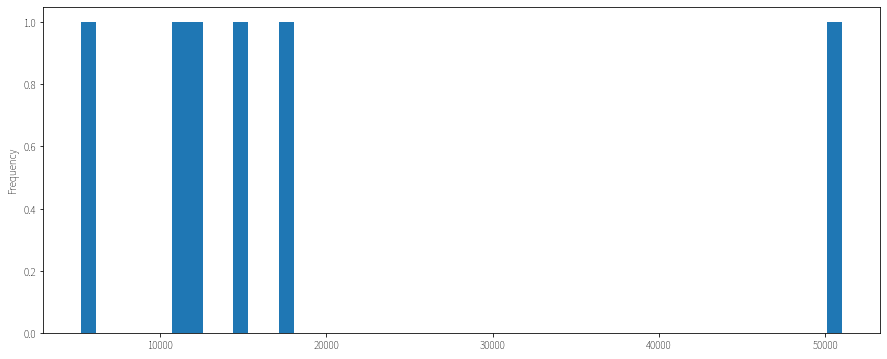

In [66]:
df[df["k_class"]==7]["floor_area"].plot.hist(bins=50)

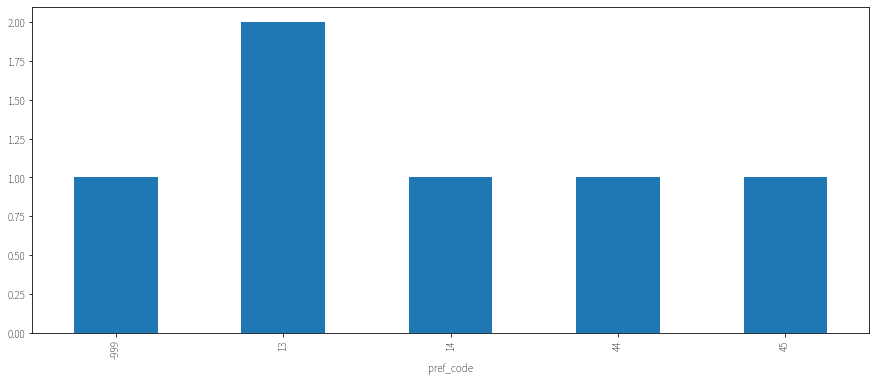

In [67]:
df[df["k_class"]==7].groupby("pref_code").size().plot.bar()

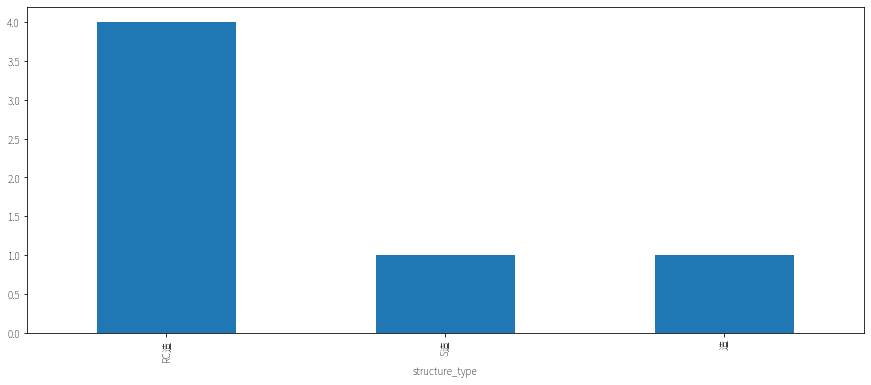

In [68]:
df[df["k_class"]==7].groupby("structure_type").size().plot.bar()

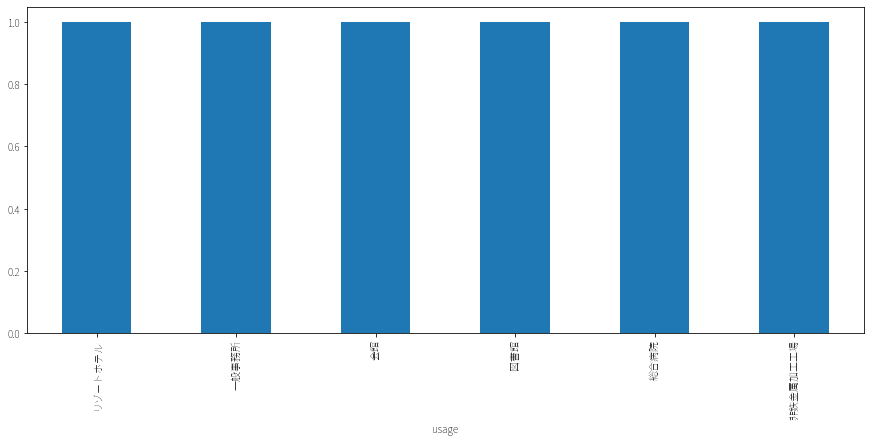

In [69]:
df[df["k_class"]==7].groupby("usage").size().plot.bar()

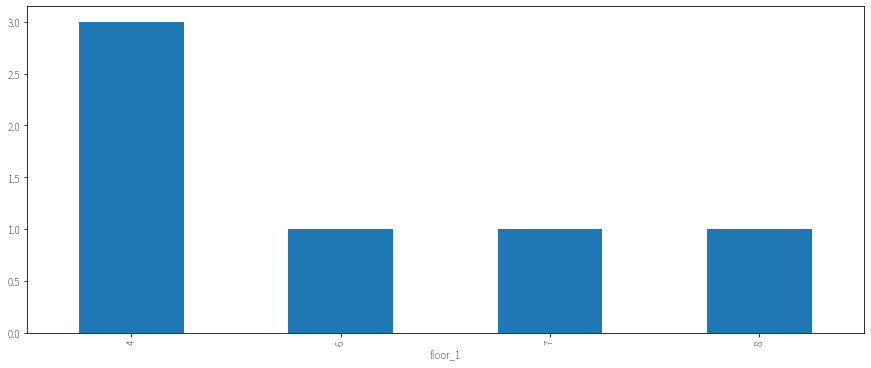

In [70]:
df[df["k_class"]==7].groupby("floor_1").size().plot.bar()

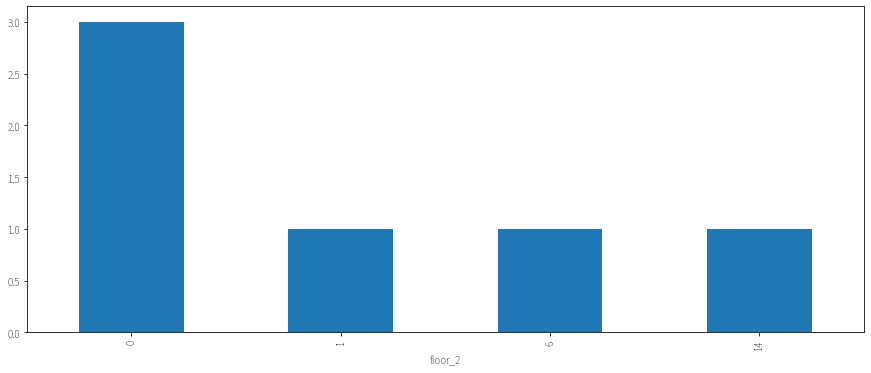

In [71]:
df[df["k_class"]==7].groupby("floor_2").size().plot.bar()

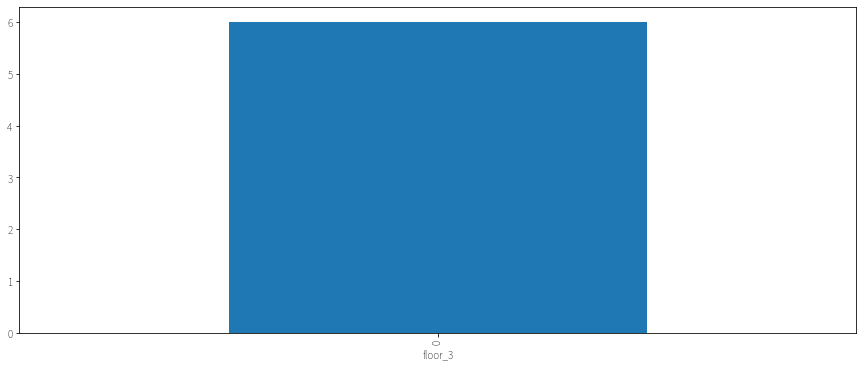

In [72]:
df[df["k_class"]==7].groupby("floor_3").size().plot.bar()

In [73]:
df[df["k_class"]==7]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
119,79 08B315D,中央合同庁舎第８号館整備（内閣府ＰＦＩ）,一般事務所,東京都千代田区,51000.00,4-14-0,RC造,13,392,4,14,0,7
315,79 10B430B,ポーラ横浜研究所跡地有効活用計画,会館,神奈川県横浜市神奈川区,14593.00,6-6-0,RC造,14,392,6,6,0,7
324,79 12A292T,山陽小野田市民病院新築工事,総合病院,0,17524.30,8-0-0,造,-999,-999,8,0,0,7
578,79 13A454E,東京大学（本郷）地下書庫躯体新営工事,図書館,東京都文京区,5243.49,7-1-0,RC造,13,392,7,1,0,7
714,74 16A009,別府サンライズホテル計画,リゾ－トホテル,大分県別府市,11748.00,4-0-0,RC造,44,392,4,0,0,7
787,74 17A001,旭化成エンジＦＴ社殿向け延岡新工場建設,非鉄金属加工工場,宮崎県延岡市,10949.00,4-0-0,S造,45,392,4,0,0,7


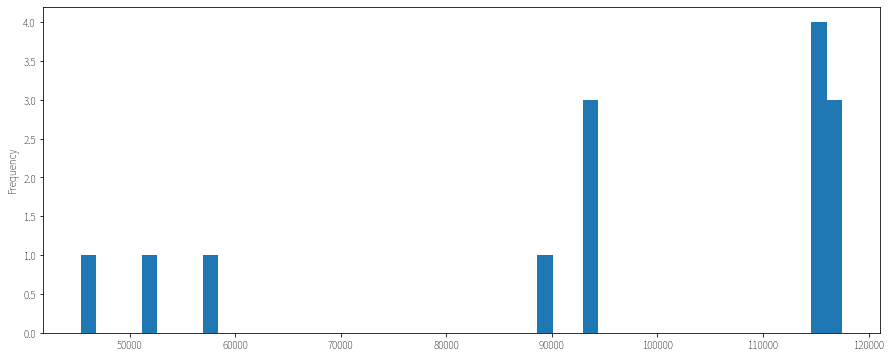

In [74]:
df[df["k_class"]==8]["floor_area"].plot.hist(bins=50)

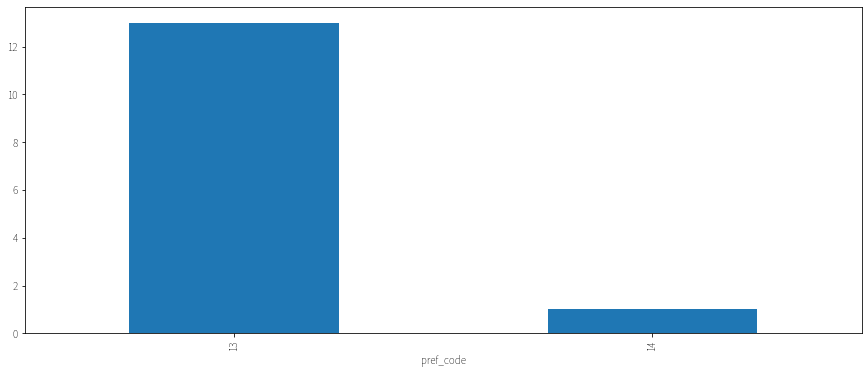

In [75]:
df[df["k_class"]==8].groupby("pref_code").size().plot.bar()

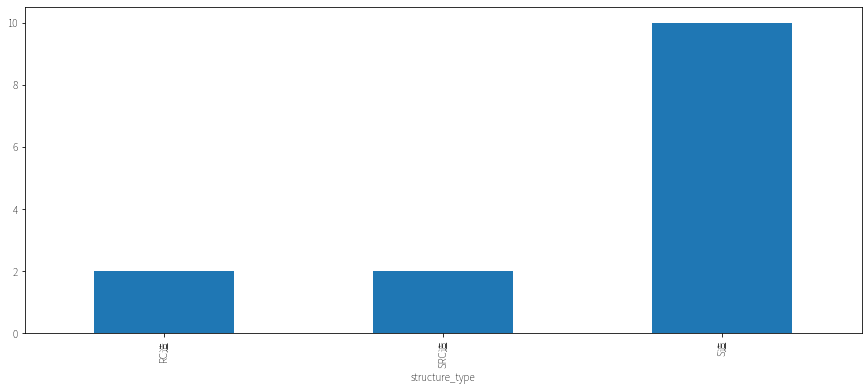

In [76]:
df[df["k_class"]==8].groupby("structure_type").size().plot.bar()

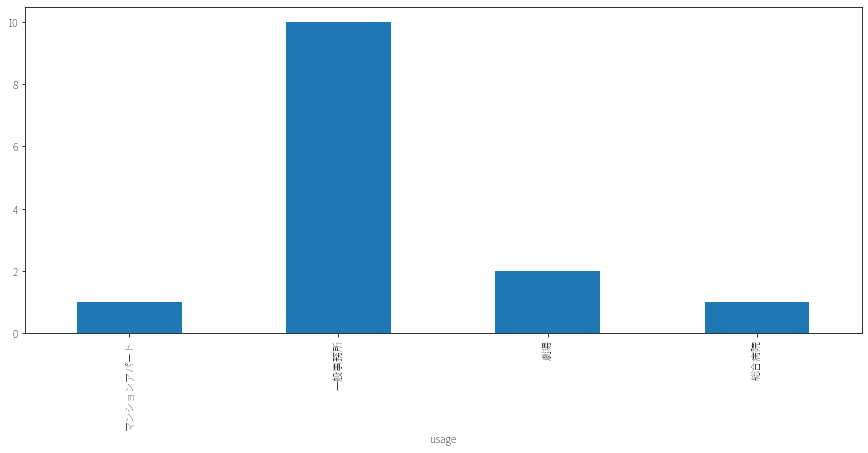

In [77]:
df[df["k_class"]==8].groupby("usage").size().plot.bar()

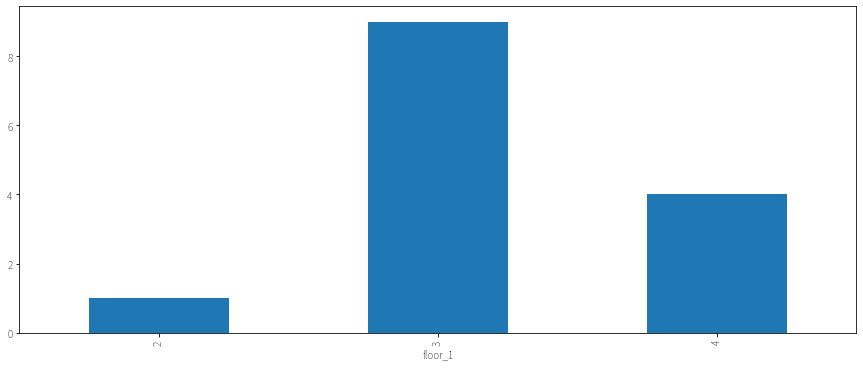

In [78]:
df[df["k_class"]==8].groupby("floor_1").size().plot.bar()

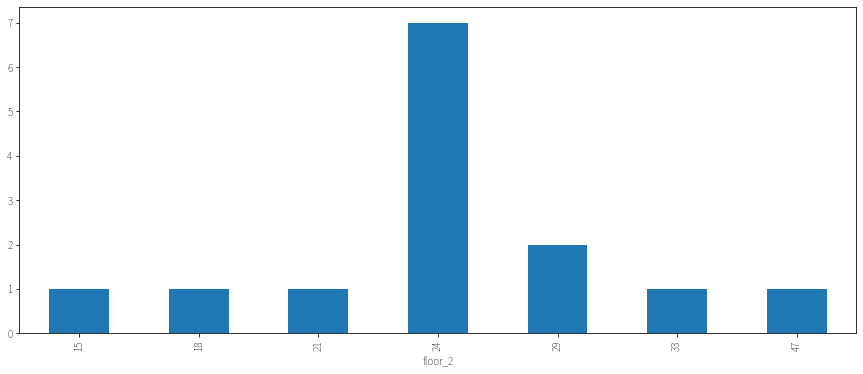

In [79]:
df[df["k_class"]==8].groupby("floor_2").size().plot.bar()

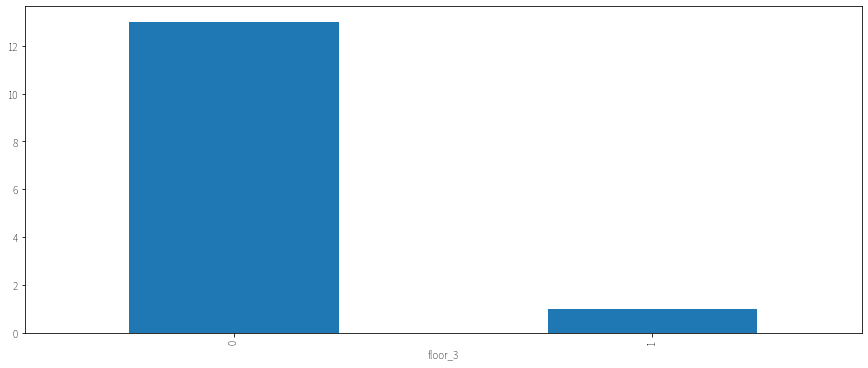

In [80]:
df[df["k_class"]==8].groupby("floor_3").size().plot.bar()

In [81]:
df[df["k_class"]==8]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
21,79 09A190B,京橋三丁目プロジェクト,一般事務所,東京都中央区,117460.96,4-24-0,S造,13,392,4,24,0,8
33,79 09A333B,順天堂本郷地区再編事業（実施設計）,総合病院,東京都文京区,45385.87,3-21-0,S造,13,392,3,21,0,8
80,79 09A190D,京橋三丁目プロジェクト設計変更対応,一般事務所,東京都中央区,116319.00,3-24-0,S造,13,392,3,24,0,8
81,79 09A190E,京橋三丁目プロジェクトＨ２２設計変更対応,一般事務所,東京都中央区,116319.00,3-24-0,S造,13,392,3,24,0,8
101,79 08B315C,中央合同庁舎第８号館整備（内閣府ＰＦＩ）,一般事務所,東京都千代田区,52349.29,3-15-1,RC造,13,392,3,15,1,8
150,79 09B056D,ＪＲ南新宿ビル新築工事,一般事務所,東京都渋谷区,58000.00,4-18-0,S造,13,392,4,18,0,8
171,79 09A181F,ＫＳプロジェクト（外部工事・屋根現寸支援,劇場,東京都中央区,93868.00,4-29-0,SRC造,13,392,4,29,0,8
182,79 11A802A,読売新聞東京本社新築工事施工支援業務,一般事務所,東京都千代田区,89409.00,3-33-0,S造,13,392,3,33,0,8
263,79 09A181G,ＫＳプロジェクト（舞台大臣囲い計画）,劇場,東京都中央区,93868.00,4-29-0,SRC造,13,392,4,29,0,8
345,79 09A190G,京橋三丁目プロジェクトＤ社入居対応工事,一般事務所,東京都中央区,114806.00,3-24-0,S造,13,392,3,24,0,8


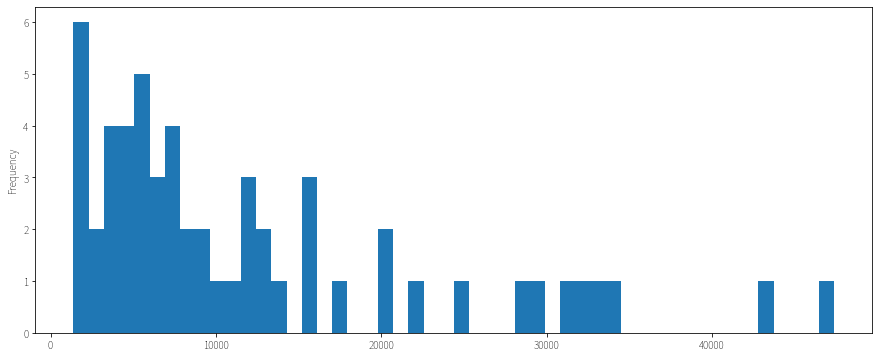

In [82]:
df[df["k_class"]==9]["floor_area"].plot.hist(bins=50)

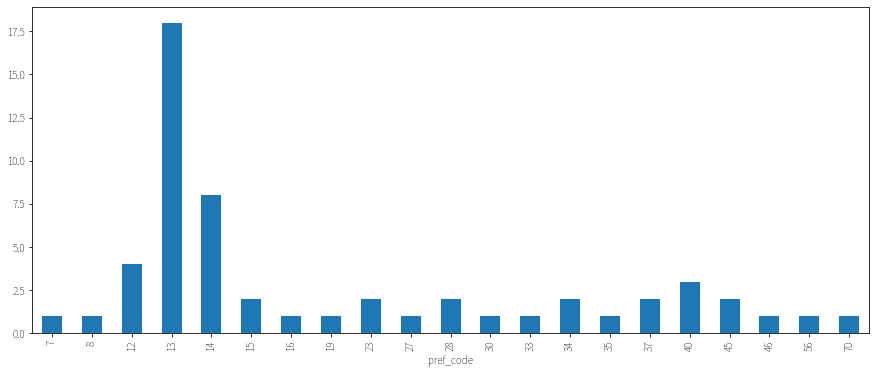

In [83]:
df[df["k_class"]==9].groupby("pref_code").size().plot.bar()

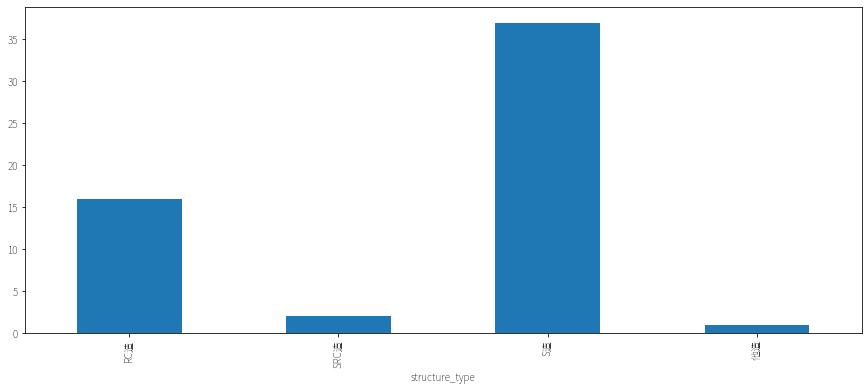

In [84]:
df[df["k_class"]==9].groupby("structure_type").size().plot.bar()

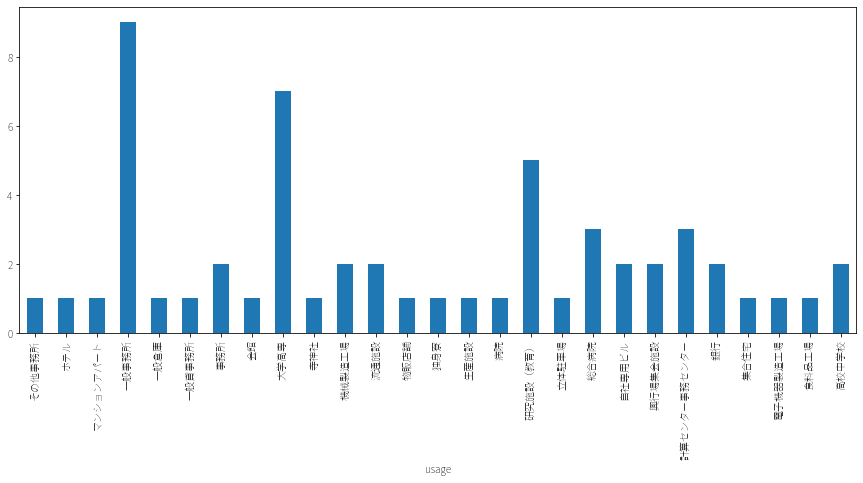

In [85]:
df[df["k_class"]==9].groupby("usage").size().plot.bar()

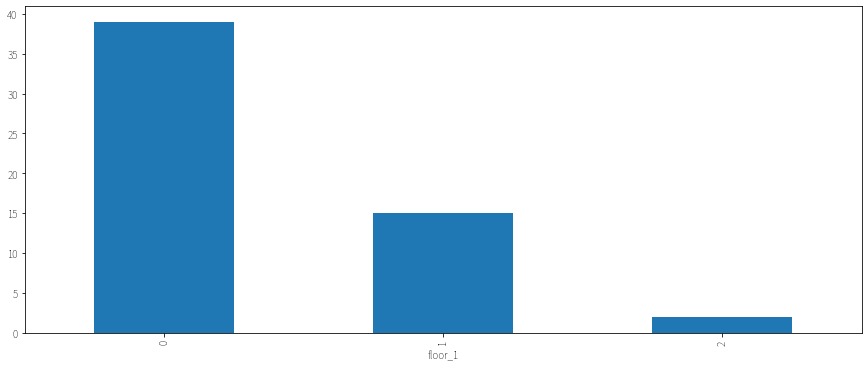

In [86]:
df[df["k_class"]==9].groupby("floor_1").size().plot.bar()

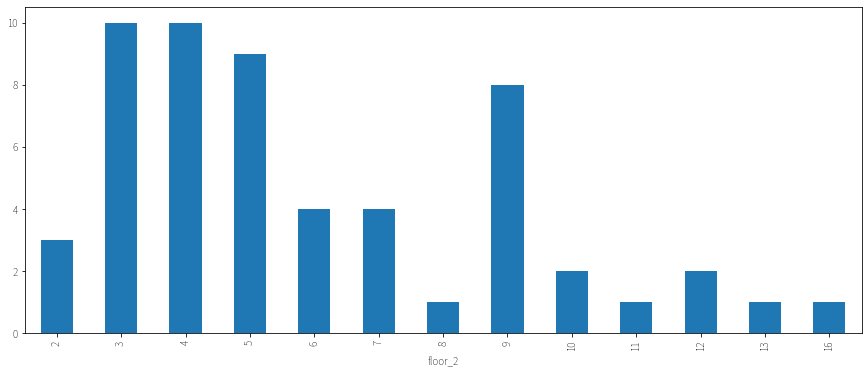

In [87]:
df[df["k_class"]==9].groupby("floor_2").size().plot.bar()

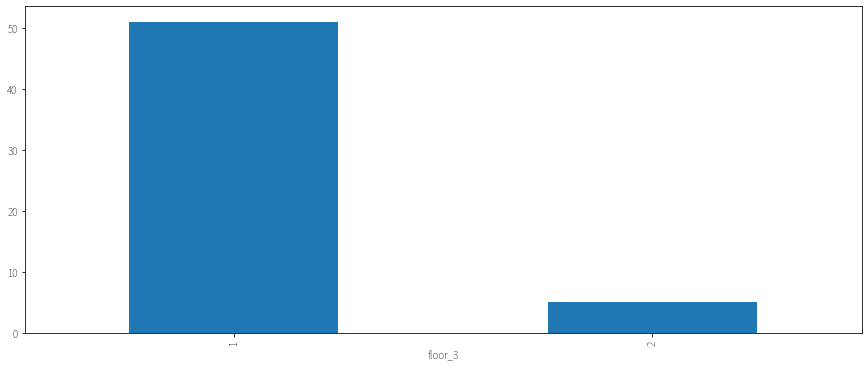

In [88]:
df[df["k_class"]==9].groupby("floor_3").size().plot.bar()

In [89]:
df[df["k_class"]==9]

,no,name,usage,place,floor_area,floor,structure_type,pref_code,country_code,floor_1,floor_2,floor_3,k_class
6,79 09A540A,花王和歌山新研究施設建設計画,研究施設（教育）,和歌山県和歌山市,22234.09,0-7-2,S造,30,392,0,7,2,9
22,79 09A276B,日本ガス協会ビル建替事業,一般事務所,東京都港区,7477.29,1-9-1,S造,13,392,1,9,1,9
34,75 09A013,立業社グループ社屋新築工事,自社専用ビル,富山県富山市,2037.00,0-4-1,S造,16,392,0,4,1,9
40,79 08B173A,川崎御幸ビルディング建替計画,一般事務所,神奈川県川崎市川崎区,6690.80,1-9-1,S造,14,392,1,9,1,9
50,79 09B524D,小田急相武台ビル（駐車場棟）工事,立体駐車場,神奈川県座間市,3290.23,0-3-1,S造,14,392,0,3,1,9
67,79 08B372B,ＮＴＴ都市開発 南麻布５丁目計画,マンションアパ－ト,東京都港区,9270.07,1-5-1,RC造,13,392,1,5,1,9
92,75 10B020,帝石直江津ＬＮＧ受入基地事務管理棟他新築,一般事務所,新潟県上越市,1795.00,0-3-1,S造,15,392,0,3,1,9
102,79 09B150B,セコム新東京病院移転新築工事,病院,千葉県松戸市,24910.84,0-7-1,RC造,12,392,0,7,1,9
125,79 09B389A,虎ノ門１丁目計画,一般事務所,東京都港区,5172.70,1-12-1,S造,13,392,1,12,1,9
149,79 10A411B,山梨県防災新館ＰＦＩ整備事業（入手後）,その他事務所,山梨県甲府市,28684.00,2-9-2,S造,19,392,2,9,2,9


In [90]:
df.groupby("structure_type").size()

structure_type
CB造       2
PC造       1
RC造     245
SC造       1
SRC造     21
S造      499
W造       15
他造        7
造        59
dtype: int64